## Trabalho 2

# 1. Aprendizado supervisionado revisitado

## 1.1. Aprendizado de Regressores

**Bibliotecas necessárias para a resolução da questão 1.1.**

In [1]:
# Manipulação de dataframes
import pandas as pd     

# Manipulação de dados tabulares
import numpy as np   

# Plotar gráficos
import matplotlib.pyplot as plt 

# Interface com o sistema operacional
import os       

# Separação do conjunto de dados em treino e teste
from sklearn.model_selection import train_test_split    

# Implementação do modelo de regressão com base no algoritmo k-NN
from sklearn.neighbors import KNeighborsRegressor        

# Busca randomizada sobre hiperparâmetros (sintonização dos hiperparâmetros)
from sklearn.model_selection import RandomizedSearchCV   

# Mean squared error regression loss
from sklearn.metrics import mean_squared_error   

# Cálculo da raiz quadrada
from math import sqrt   

# Implementação do modelo de regressão com base no algoritmo Decision Tree
from sklearn.tree import DecisionTreeRegressor    

# Normalização das características
from sklearn.preprocessing import StandardScaler  

# Coeficiente de determinação
from sklearn.metrics import r2_score

### 1.1.1. Aprendizado com uma variável

**Objetivos da questão**

* Ajustar diversos modelos de regressão para predizer o lucro para uma cadeia de *food truck.*

* Criar modelos de regressão com as seguintes implementações fornecidas pela biblioteca Scikit-Learn. Em cada caso, realizar a sintonização dos hiperparâmetros.

Observação: nesta questão não há necessidade de normalização, pois estamos trabalhando somente com uma feature.

**Dados da questão**

* O arquivo `ex1data1.txt` contém os dados a serem usados nessa parte do trabalho.

* 1ª coluna do dataset: população de cada cidade.

* 2ª coluna do dataset: lucro da filial daquela cidade.

* Um valor negativo para o lucro indica que a filial correspondente está dando prejuízo.

#### Parte 1: Importação, leitura e visualização dos dados

**Leitura dos Dados**

In [2]:
# Função para importação dos dados
def read_dataset(filepath):
    # leitura de arquivo ".csv"
    data = pd.read_csv(filepath, header=None)

    # Matriz de dados
    X = np.array(data.iloc[:, :-1])
    
    # Vetor de resposta
    y = np.array(data.iloc[:, 1])

    return X, y

In [3]:
# URL onde está o arquivo
filepath = 'Data/ex1data1.txt'

# Leitura dos dados
X, y = read_dataset(filepath)

**Visualização dos dados**

In [4]:
# Função para plotar gráfico de dispersão
def plot(X, y):
    plt.figure(figsize = (10,6))
    
    # Criação do gráfico de dispersão
    plt.scatter(X.T, y, color='red', marker='x')
    
    # Título
    plt.title('População da cidade x Lucro da filial')
    
    # Rótulos
    plt.xlabel('População da cidade (10k)')
    plt.ylabel('Lucro (10k)')

    # Opção para salvar o gráfico como imagem
    filename = 'target/plot1.1.png'
    if not os.path.exists(os.path.dirname(filename)):
      os.makedirs(os.path.dirname(filename))

    plt.savefig(filename)
    
    # Exibição do gráfico
    plt.show()

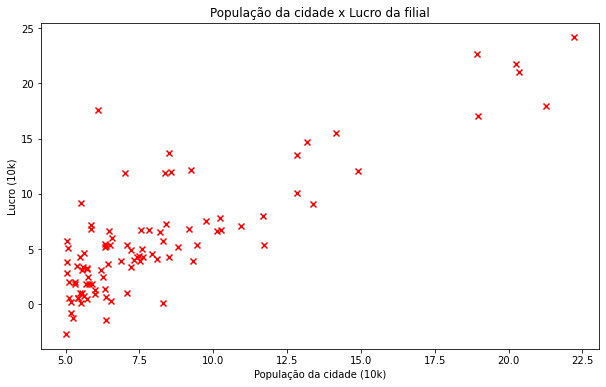

In [5]:
# Visualização dos dados - Gráfico de dispersão
plot(X, y)

#### Parte 2: Criação, ajustamento e avaliação de modelos de regressão¶

**Divisão do dataset original em conjuntos de treino e de teste**

Nas tarefas de Aprendizado de Máquinas é preciso ajustar o modelo com algum algoritmo de aprendizado e avaliar objetivamente se o modelo gerado é um modelo apropriado, ou seja, se consegue generalizar para dados que não foram vistos durante a etapa de treinamento do modelo. Uma vez que não adequado avaliar o desempenho de um modelo utilizando o mesmo conjunto de dados utilizado para treiná-lo, torna-se necessário dividir este dataset original em 2 subconjuntos (conjunto de dados de treinamento e conjunto de dados de teste).

Para o desenvolvimento da questão, foi utilizado o método *Two-way holdout* para separação do dataset original. Para este fim, foi utilizada a classe `train_test_split` do Scikit-Learn. Portanto, a partir de uma matriz de dados ($\mathrm{X}$) e um vetor de resposta ($\mathrm{y}$), o `train_test_split` retorna com 2 matrizes de dados ($\mathrm{X_{train}}$ e $\mathrm{X_{test}}$) e 2 vetores de resposta ($\mathrm{y_{train}}$ e $\mathrm{y_{test}}$). Por fim, foi utilizada a proporção de 70% do dataset original para o conjunto de treino e 30% para o conjunto de teste.

**Observação importante**: o `train_test_split` realiza a divisão do dataset original de forma aleatória. Portanto, para fins de reprodutibilidade do modelo, utiliza-se o parâmetro `random_state`a fim de evitar que sejam gerados diferentes conjuntos de treino e de teste a cada execução do `train_test_split` (segundo a documentação do `train_test_split`, o `random_state` controla o embaralhamento dos dados antes da divisão do dataset original).  

In [6]:
# Divisão do conjunto de dados em 2 subconjuntos (treino e teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3,
                                                    random_state = 31)

# Argumentos da função "train_test_split"
# 1º argumento: X => matriz de dados
# 2º argumento: y => vetor de resposta
# 3º argumento: test_size => % do conjunto de dados que ficará no conjunto de treino e que ficará no conjunto de teste
# 4º argumento: random_state => garante que o mesmo split seja feito (utilizando o mesmo conjunto de dados)
# 5º argumento: stratify=y => assegura proporções similares dos conjuntos de dados de treino e de teste (das classes)
# obs.: stratify = y é indicado quando o dataset é desbalanceado.

**(a)Algoritmo k-NN (k-Nearest Neighbors)**

**Aspectos Conceituais**

O algoritmo k-NN é o algoritmo de aprendizado de máquinas mais simples, visto que a construção do modelo consiste do armazenamento do dataset de treinamento. Portanto, para prever um novo ponto de dado, o algoritmo localiza os pontos de dados mais próximos do conjunto de dados de treinamento (isto é, os vizinhos mais próximos).

No caso da aplicação do algoritmo k-NN à tarefa de regressão, o objetivo do modelo é localizar os valores do atributo alvo (variável contínua alvo) dos $\mathrm{k}$ vizinhos mais próximos e calcular a média desses valores alvo como o valor alvo predito.

**Ajustamento do modelo de regressão**

A classe `KNeighborsRegressor` do Scikit-Learn implementa a versão do k-NN para a tarefa de regressão.

Uma vez definida a k vizinhança em torno do objeto que será predito, são atribuídos pesos para cada exemplo dentro da $k$ vizinhança, de modo que quanto maior for a distância que o exemplo da $k$ vizinhança estiver do exemplo a ser predito, menor será a sua importância no rótulo do novo exemplo. Por fim, este peso é atribuída pelo argumento `weights` da classe `KNeighborsRegressor`.

In [7]:
# Criação do objeto de regressão (sem a definição arbitrária do valor do hiperparâmetro k)
modelKNN_rs = KNeighborsRegressor(weights = 'distance')

# por default, o algoritmo utiliza "p = 2" (distância euclidiana)
# Argumento "weights": função de peso utilizada na predição.
# weights = ‘distance’ => os pesos dos pontos de dados são obtidos pela inversa da suas distâncias.

Diferentemente dos parâmetros do modelo, que são aprendidos durante a etapa de aprendizado, os valores dos hiperparâmetros são construídos anters do treinamento de um modelo inicial. Uma vez que os hiperparâmetros podem ser considerados como configurações de um algoritmo de aprendizado, o ideal é utilizar o procedimento de otimização dos hiperparâmetros a fim de definir a combinação de hiperparâmetros que sejam mais adequadas para o algoritmo de aprendizado em questão.

Uma das estratégias para otimizar (ou sintonizar) a melhor combinação de hiperparâmetros é a *Random Search*, que seleciona combinações aleatórias dos valores dos hiperparâmetros (dentro do intervalo pré-configurado para cada hiperparâmetro) para treinar e avaliar os modelos candidatos. Diferente do *Grid Search*, que testa todos os valores possíveis dos hiperparâmetros, o *Random Search* utiliza um conjunto fixo de hiperparâmetros para encontrar a combinação ótima de hiperparâmetrs.

No caso do algoritmo k-NN, o hiperparâmetro que será sintonizado é o valor de $k$ (número dos vizinhos mais próximos). Além disso, a otimização do hiperparâmetro será realizada por meio da classe `RandomizedSearchCV` do Scikit-Learn.

A classe `RandomizedSearchCV`, além de realizar a busca randomizada da combinação dos hiperparâmetros, utiliza esta combinação para ajustar o modelo no conjunto de treinamento (por meio do método `fit`) e fornece o coeficiente de determinação $\mathrm{R^2}$ da predição (por meio do método `score`).

**Observação**: o argumento `scoring` da classe `RandomizedSearchCV` segue a convenção de que os valores de retorno mais altos são melhores do que os valores de retorno mais baixo. Diante disso, as métricas que calculam a distância entre o modelo e os dados estão disponíveis como `neg_mean_squared_error`, que retorna o valor negativo da métrica. 

In [8]:
# Definição do intervalo pré-configurado para a sintonização do hiperparâmetro k
KNN_rs_param = {'n_neighbors': list(range(1, 30))}

# n_neighbors: nº de vizinhos (hiperparâmetro k do k-NN)

In [9]:
# Busca randomizada da combinação dos hiperparâmetros
kNN_rs_random_search = RandomizedSearchCV(modelKNN_rs,
                                          KNN_rs_param,
                                          n_iter = 20,
                                          cv = 5,
                                          scoring = 'neg_mean_squared_error')

# 1º argumento: modelo para o qual desejamos otimizar os parâmetros (modelKNN_rs)
# 2º argumento: vetor de parâmetros utilizados que serão otimizados (KNN_rs_param)
# 3º argumento: nº de configurações de parâmetros que são testadas  (n_iter). O default é "n_iter = 10".
# 4º argumento: gerador de validação cruzada (cv) => quantidade de folds
# 5º argumento: estratégia para avaliar o desempenho do modelo com validação cruzada no conjunto de teste (scoring)

O atributo `fit` é utilizado para ajustar o modelo utilizando as combinações aletaórias dos hiperparâmetros gerados pela classe `RandomizedSearchCV`.

In [10]:
# Treinamento do modelo usando as combinações aleatórias de hiperparâmetros geradas pelo RandomizedSearchCV
kNN_rs_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(weights='distance'),
                   n_iter=20,
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29]},
                   scoring='neg_mean_squared_error')

O atributo `best_params_` retorna a configuração do hiperparãmetro que forneceu os melhores resultados.

In [11]:
# Identificação do hiperparâmetro ótimo
k_rs = kNN_rs_random_search.best_params_['n_neighbors']
print("Valor do hiperparâmetro ótimo (nº ótimo de vizinhos): {}".format(k_rs))

Valor do hiperparâmetro ótimo (nº ótimo de vizinhos): 7


O atributo `best_score_` retorna o *score* médio da validação cruzada do `best_estimator`.

In [12]:
# RMSE do modelo do hiperparâmetro ótimo
kNN_rs_best_score = np.sqrt(-kNN_rs_random_search.best_score_)
print("RMSE do modelo com o hiperparâmetro ótimo: {:.2f}".format(kNN_rs_best_score))

RMSE do modelo com o hiperparâmetro ótimo: 2.80


**Predição do modelo**

In [13]:
# Predição dos valores dos exemplos que não foram vistos na etapa de treinamento
modelKNN_rs_best = kNN_rs_random_search.best_estimator_     # estimador do melhor modelo escolhido
y_pred_KNN_rs = modelKNN_rs_best.predict(X_test)
print("Valores preditos: {}".format(y_pred_KNN_rs.T))

Valores preditos: [ 1.82823377  5.37342652  2.31359242  3.05442048  0.64253368  1.94779856
  3.48741601  3.41779725  4.39539053  2.6793548   5.26357605  5.57259949
  0.54853721  1.83512879  4.75370897  4.66581674  3.30977174  4.06536821
 22.5365252   4.33946938  4.43770877  1.2311287   2.00559866  1.01773497
  2.75534138  2.8856487   0.84882182 13.36225064  2.20116111  7.47592869]


Enquanto o RMSE corresponde a uma medida do desvio médio (ao quadrado) entre o valor observado ($y$) e predito ($\hat{y}$), o coeficiente de determinação ($\mathrm{R}^2$) mede o grau de ajustamento do modelo de regressão ao conjunto de dados (mede o % da variância total nos dados observados que pode ser explicado pelo modelo). Em outras palavras, o $\mathrm{R}^2$ mede quão bem a reta de regressão se ajusta ao conjunto de dados.

In [14]:
# RMSE do modelo
modelKNN_rs_score_pred = np.sqrt(mean_squared_error(y_test, y_pred_KNN_rs))
print('RMSE do modelo: {:.2f}'.format(modelKNN_rs_score_pred))

RMSE do modelo: 4.61


In [15]:
# Coeficiente de determinação (R2) do modelo (0 <= R2 <= 1)
modelKNN_rs_r2 = r2_score(y_test, y_pred_KNN_rs)
print("Coeficiente de determinação do modelo: {:.2f}".format(modelKNN_rs_r2))

Coeficiente de determinação do modelo: 0.03


**(b) Algoritmo de indução de árvores de decisão**

**Aspectos conceituais**

O algoritmo de indução de árovres de decisão pode ser utilizado em modelos para tarefas de classificação e de regressão. É uma ferramenta de tomada de decisão (ou modelo de decisão) que utiliza um fluxograma com uma estrutura tipo árvore. Os galhos da árvore representam o resultado do nó e os nós podem possuir condições (nós de decisão) ou resultados (nós terminais).

No caso da tarefa de regressão, o algoritmo de indução de árvore de decisão observa as *features* de um objeto e treina um modelo na estrutura de uma árvores para predizer o valor do atributo alvo.

**Ajustamento do modelo de regressão**

A classe `DecisionTreeRegressor` do Scikit-Learn implementa a versão do algoritmo de indução para Árvore de Decisão para a tarefa de regressão.

Como default, a classe `DecisionTreeRegressor` utiliza o argumento `spliter: best`, indicando a escolha da melhor estratégia de divisão em cada.

In [16]:
# Criação do objeto de regressão (sem a definição arbitrária do valor do hiperparâmetro "max_depth")
modelDT_rs = DecisionTreeRegressor(random_state = 0)

# Argumento "random_state": controla a aleatoriedade do estimador.

Semelhantemente ao observado para o caso do k-NN, no algoritmo de indução de Árvore de Decisão o ideal é utilizar o procedimento de otimização dos hiperparâmetros a fim de definir a combinação de hiperparâmetros que sejam mais adequadas para o algoritmo de aprendizado em questão.

No caso do algoritmo de indução de Árvore de Decisão, o hiperparâmetro que será sintonizado é o tamanho máximo da árvore. Seguindo o desenvolvimento observado para o caso do k-NN, para o algoritmo de induçaõ da Árvore de Decisão a otimização do hiperparâmetro será realizada por meio da classe `RandomizedSearchCV` do Scikit-Learn.

In [17]:
# Definição do intervalo pré-configurado para a sintonização do hiperparâmetro "max_depth"
DT_rs_param = {'max_depth': [None] + list(range(2, 30)),'criterion': ['mse', 'friedman_mse', 'mae']}

# Argumento "max_depth": altura máxima da árvore que será induzida
# Argumento "criterion": medida da qualidade da divisão
# Critérios suportados pelo argumento "criterion": mse, friedman_mse, mae

In [18]:
# Busca randomizada da combinação dos hiperparâmetros
DT_rs_random_search = RandomizedSearchCV(modelDT_rs,
                                         DT_rs_param,
                                         n_iter = 20,
                                         cv = 5,
                                         scoring = 'neg_mean_squared_error')

# 1º argumento: modelo para o qual desejamos otimizar os parâmetros (modelDT_rs)
# 2º argumento: vetor de parâmetros utilizados que serão otimizados (DT_rs_param)
# 3º argumento: nº de configurações de parâmetros que são testadas  (n_iter). O padrão é "n_iter = 10".
# 4º argumento: gerador de validação cruzada (cv)
# 5º argumento: estratégia para avaliar o desempenho do modelo com validação cruzada no conjunto de teste (scoring)

In [19]:
# Treinamento do modelo usando as combinações aleatórias de hiperparâmetros geradas pelo RandomizedSearchCV
DT_rs_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
                   n_iter=20,
                   param_distributions={'criterion': ['mse', 'friedman_mse',
                                                      'mae'],
                                        'max_depth': [None, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29]},
                   scoring='neg_mean_squared_error')

In [20]:
# Identificação do hiperparâmetro ótimo
depth_rs = DT_rs_random_search.best_params_['max_depth']
print("Valor do hiperparâmetro ótimo (altura ótima da árvore): {}".format(depth_rs))

Valor do hiperparâmetro ótimo (altura ótima da árvore): 2


In [21]:
# RMSE do modelo do hiperparâmetro ótimo
DT_rs_best_score = np.sqrt(-DT_rs_random_search.best_score_)
print("RMSE do modelo com o hiperparâmetro ótimo: {:.2f}".format(DT_rs_best_score))

RMSE do modelo com o hiperparâmetro ótimo: 2.76


In [22]:
# Critério utilizado para avaliar para a qualidade da divisão
DT_rs_split_criteria = DT_rs_random_search.best_params_['criterion']
print("Critério para a qualidade da divisão: {}".format(DT_rs_split_criteria))

Critério para a qualidade da divisão: mae


**Predição do modelo**

In [23]:
# Predição dos valores dos exemplos que não foram vistos na etapa de treinamento
modelDT_rs_best = DT_rs_random_search.best_estimator_
y_pred_DT_rs = modelKNN_rs_best.predict(X_test)
print("Valores preditos: {}".format(y_pred_DT_rs.T))

Valores preditos: [ 1.82823377  5.37342652  2.31359242  3.05442048  0.64253368  1.94779856
  3.48741601  3.41779725  4.39539053  2.6793548   5.26357605  5.57259949
  0.54853721  1.83512879  4.75370897  4.66581674  3.30977174  4.06536821
 22.5365252   4.33946938  4.43770877  1.2311287   2.00559866  1.01773497
  2.75534138  2.8856487   0.84882182 13.36225064  2.20116111  7.47592869]


Enquanto o RMSE corresponde a uma medida do desvio médio (ao quadrado) entre o valor observado ($y$) e predito ($\hat{y}$), o coeficiente de determinação ($\mathrm{R}^2$) mede o grau de ajustamento do modelo de regressão ao conjunto de dados (mede o % da variância total nos dados observados que pode ser explicado pelo modelo). Em outras palavras, o $\mathrm{R}^2$ mede quão bem a reta de regressão se ajusta ao conjunto de dados.

Uma medida similar ao RMSE é o MAE (erro médio absoluto), que mede o desvio médio (em termos absolutos) entre o valor observado ($y$) e predito ($\hat{y}$).

In [24]:
# RMSE do modelo
modelDT_rs_score_pred = np.sqrt(mean_squared_error(y_test, y_pred_DT_rs))
print('RMSE do modelo: {:.2f}'.format(modelDT_rs_score_pred))

RMSE do modelo: 4.61


In [25]:
# Coeficiente de determinação (R2) do modelo (0 <= R2 <= 1)
modelDT_rs_r2 = r2_score(y_test, y_pred_DT_rs)
print("Coeficiente de determinação do modelo: {:.2f}".format(modelDT_rs_r2))

Coeficiente de determinação do modelo: 0.03


Tabela comparativa entre os modelos univariado e multivariado: 

| Modelo | RMSE do modelo | $\mathrm{R}^2$ do modelo|
| :---: | :---: | :---: | 
| k-NN univariado | 4.61 | 0.03 |
| DT univariado | 4.61 | 0.03 | 

Pelos resultados da tabela acima, é possível observar que ambos os modelos univariados apresentaram desempenho similar.

### 1.1.2. Regressão com múltiplas variáveis

**Objetivos da questão**

* Criar modelos de regressão a partir de um conjunto de dados que possui múltiplas variáveis preditoras.

* Normalizar as características.

* Criar modelos de regressão com algoritmos fornecidos pela biblioteca Scikit-Learn.

**Dados da questão**

* O arquivo `ex1data2.txt` contém informações acerca de preços de imóveis.

* 1ª coluna do dataset: tamanho do imóvel (em pés quadrados).

* 2ª coluna do dataset: quantidade de dormitós no imóvel em questão.

* 3ª coluna do dataset: preço do imóvel.

* Um valor negativo para o lucro indica que a filial correspondente está dando prejuízo.

#### Parte 1: Leitura dos dados

In [26]:
# Leitura dos dados
filepath = 'Data/ex1data2.txt'

X, y = read_dataset(filepath)

#### Parte 2: Criação, ajustamento e avaliação de modelos de regressão

**Divisão do dataset original em conjuntos de treino e de teste**

Semelhante ao desenvolvimento do item 1.1.1., para esta questão foi utilizado o método *Two-way holdout* para separação do dataset original. Para este fim, foi utilizada a classe `train_test_split` do Scikit-Learn. Portanto, a partir de uma matriz de dados ($\mathrm{X}$) e um vetor de resposta ($\mathrm{y}$), o `train_test_split` retorna com 2 matrizes de dados ($\mathrm{X_{train}}$ e $\mathrm{X_{test}}$) e 2 vetores de resposta ($\mathrm{y_{train}}$ e $\mathrm{y_{test}}$). Por fim, foi utilizada a proporção de 70% do dataset original para o conjunto de treino e 30% para o conjunto de teste.

In [27]:
# Divisão do conjunto de dados em 2 subconjuntos (treino e teste)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 31)

# Argumentos da função "train_test_split"
# 1º argumento: X => matrizes de dados
# 2º argumento: y => vetor de resposta
# 3º argumento: test_size => % do conjunto de dados que ficará no conjunto de treino e que ficará no conjunto de teste
# 4º argumento: random_state => garante que o mesmo split seja feito (utilizando o mesmo conjunto de dados)
# obs.: random_state é utilizado para garantir reprodutibilidade do modelo
# 5º parâmetro: stratify=y => assegura proporções similares dos conjuntos de dados de treino e de teste (das classes)

**Normalização das Características (*feature scaling*)**

Nos modelos de aprendizado de máquinas, a escala e a distribuição dos atributos podem diferir bastante entre eles. Neste sentido, os atributos da matriz de dados podem ser mensurados em diferentes escalas. Contudo, as diferenças entre as escalas de medida dos atributos da matriz de dados podem aumenta a dificuldade para modelar o problema em questão, principalmente em algortimos baseados em distância.

O indicado para lidar com as diferenças nas escalas de medidas dos atributos é a normalização das características. Uma das técnicas de normalização das características é a padronização (terminologia retirada da estatística), que corresponde à transformação do atributo em uma variável normal padrão (com $\mu = 0$ e $\sigma = 1$). Diante disso, é possível representar esta técnica por meio da seguinte expressão:

$$
Z_i = \frac{X_i - \mu_i}{\sigma_i}
$$

onde $X_i$ é o atributo $i$ da matriz de dados, $\mu_i$ e $\sigma_i$ são a média e o desvio padrão de $X_i$, respectivamente. Por fim, $X_i \sim N(\mu_i,\sigma_i)$ e $Z_i \sim N(0,1)$. Portanto, o resultado da padronização é um conjunto de atributos com média zero e desvio padrão 1. Em outras palavras, a padronização assume que as features se ajustam a uma distribuição Gaussiana (distribuitção normal).

A classe `StandardScaler` do Scikit-Learn é utilizada para lidar com as diferenças de ordens de grandezas entre as features. Assim, a utilização desta classe permite que as features tenham ordens de grandeza similares.

O `StandardScaler` calcula a média e o desvio padrão de cada coluna do dataset e depois realiza a subtração de cada valor pela média calculada e a divisão do resultado da subtração pelo desvio padrão calculado. Contudo, antes de aplicar o `StandardScaler` aos dados de treino e de teste, é preciso ajustá-lo ao conjunto de treinamento. Essa prática evita que qualquer informação do conjunto de teste seja vista pelo conjunto de treinamento.

In [28]:
# Criação do objeto para a padronização das features
rm_scaler = StandardScaler()

# Ajustamento do StandardScaler ao conjunto de dados de treino e padronização dos dados de treino
X_train_norm = rm_scaler.fit_transform(X_train)       

# rm_scaler.fit(X_train) => ajusta os parâmetros para padronização a partir dos dados de treino
# rm_scaler.fit(X_train) => Cálculo da média e do desvio padrão que serão utilizados para padronização das features
# rm_scaler.transform(X_train) => padronização dos dados de treino
# "rm_scaler.fit_transform(X_train)" corresponde a "rm_scaler.fit(X_train)" e "rm_scaler.transform(X_train)"

# Transformação dos dados de teste com os parâmetros ajustados a partir dos dados de treino
X_test_norm = rm_scaler.transform(X_test)   

**(a) Algoritmo k-NN (k-Nearest Neighbors)**

**Ajustamento do modelo de regressão**

In [29]:
# Criação do objeto de regressão (sem a definição arbitrária do número de vizinhos)
modelKNN_rm = KNeighborsRegressor(weights = 'distance')

# por default, o algoritmo utiliza "p = 2" (distância euclidiana)
# Argumento "weights": função de peso utilizada na predição.
# weights = ‘distance’ => os pesos dos pontos de dados são obtidos pela inversa da suas distâncias.

In [30]:
# Definição do intervalo pré-configurado para a sintonização do hiperparâmetro k
KNN_rm_param = {'n_neighbors': list(range(1, 20))}

# n_neighbors: nº de vizinhos (hiperparâmetro k do k-NN)

In [31]:
# Busca randomizada da combinação dos hiperparâmetros
kNN_rm_random_search = RandomizedSearchCV(modelKNN_rm,
                                          KNN_rm_param,
                                          n_iter = 20,
                                          cv = 10,
                                          scoring = 'neg_mean_squared_error')

# 1º argumento: modelo para o qual desejamos otimizar os parâmetros (modelKNN_rs)
# 2º argumento: vetor de parâmetros utilizados que serão otimizados (KNN_rs_param)
# 3º argumento: nº de configurações de parâmetros que são testadas  (n_iter). O default é "n_iter = 10".
# 4º argumento: gerador de validação cruzada (cv) => quantidade de folds
# 5º argumento: estratégia para avaliar o desempenho do modelo com validação cruzada no conjunto de teste (scoring)

In [32]:
# Treinamento do modelo usando as combinações aleatórias de hiperparâmetros geradas pelo RandomizedSearchCV
kNN_rm_random_search.fit(X_train_norm, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 19 is smaller than n_iter=20. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(weights='distance'),
                   n_iter=20,
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19]},
                   scoring='neg_mean_squared_error')

In [33]:
# Identificação do hiperparâmetro ótimo
k_rm = kNN_rm_random_search.best_params_['n_neighbors']
print("Valor do hiperparâmetro ótimo (nº ótimo de vizinhos): {}".format(k_rm))

Valor do hiperparâmetro ótimo (nº ótimo de vizinhos): 4


In [34]:
# RMSE do modelo do hiperparâmetro ótimo
kNN_rm_best_score = np.sqrt(-kNN_rm_random_search.best_score_)
print("RMSE do modelo com o hiperparâmetro ótimo: {:.2f}".format(kNN_rm_best_score))

RMSE do modelo com o hiperparâmetro ótimo: 0.22


**Predição do modelo**

In [35]:
# Predição dos valores dos exemplos que não foram vistos na etapa de treinamento
modelKNN_rm_best = kNN_rm_random_search.best_estimator_
y_pred_modelKNN_rm = modelKNN_rm_best.predict(X_test_norm)
print("Valores preditos: {}".format(y_pred_modelKNN_rm.T))

Valores preditos: [3.79768671 2.         3.         3.         4.         4.
 4.         3.         3.         3.         2.         3.
 3.         3.         4.        ]


Enquanto o RMSE corresponde a uma medida do desvio médio (ao quadrado) entre o valor observado ($y$) e predito ($\hat{y}$), o coeficiente de determinação ($\mathrm{R}^2$) mede o grau de ajustamento do modelo de regressão ao conjunto de dados (mede o % da variância total nos dados observados que pode ser explicado pelo modelo). Em outras palavras, o $\mathrm{R}^2$ mede quão bem a reta de regressão se ajusta ao conjunto de dados.

Uma medida similar ao RMSE é o MAE (erro médio absoluto), que mede o desvio médio (em termos absolutos) entre o valor observado ($y$) e predito ($\hat{y}$).

In [36]:
# RMSE do modelo
modelKNN_rm_score_pred = np.sqrt(mean_squared_error(y_test, y_pred_modelKNN_rm))
print('RMSE do modelo: {:.2f}'.format(modelKNN_rm_score_pred))

RMSE do modelo: 0.31


In [37]:
# Coeficiente de determinação (R2) do modelo (0 <= R2 <= 1)
modelKNN_rm_r2 = r2_score(y_test, y_pred_modelKNN_rm)
print("Coeficiente de determinação do modelo: {:.2f}".format(modelKNN_rm_r2))

Coeficiente de determinação do modelo: 0.84


Tabela comparativa entre os modelos univariado e multivariado: 

| Modelo | Hiperparâmetro ótimo | RMSE do hiperparâmetro ótimo | RMSE do modelo | $\mathrm{R}^2$ do modelo|
| :---: | :---: | :---: | :---: | :---: |
| k-NN univariado | $k=7$ | 2.80 | 4.61 | 0.03 |
| k-NN multivariado | $k=4$ | 0.22 | 0.31 | 0.84 |

Pelos resultados da tabela acima, é possível observar que o k-NN multivariado apresentou um desempenho melhor tanto com relação ao hiperparâmetro ótimo como também com relação ao desempenho do modelo resultante, visto que em ambos os casos o RMSE do modelo multivariado foi menor. Além disso, o modelo multivariado apresentou $\mathrm{R}^2$ superior ao do modelo univariado.

**(b) Algoritmo de indução de árvores de decisão**

**Ajustamento do modelo de regressão**

In [38]:
# Criação do objeto de regressão (sem a definição arbitrária do valor do hiperparâmetro "max_depth")
modelDT_rm = DecisionTreeRegressor(random_state = 0)

# Argumento "random_state": controla a aleatoriedade do estimador.

In [39]:
# Definição do intervalo pré-configurado para a sintonização do hiperparâmetro "max_depth"
DT_rm_param = {'max_depth': [None] + list(range(2, 30)),'criterion': ['mse', 'friedman_mse', 'mae']}

# Argumento "max_depth": altura máxima da árvore que será induzida
# Argumento "criterion": medida da qualidade da divisão
# Critérios suportados pelo argumento "criterion": mse, friedman_mse, mae

In [40]:
# Busca randomizada da combinação dos hiperparâmetros
DT_rm_random_search = RandomizedSearchCV(modelDT_rm,
                                         DT_rm_param,
                                         n_iter = 20,
                                         cv = 10,
                                         scoring = 'neg_mean_squared_error')

# 1º argumento: modelo para o qual desejamos otimizar os parâmetros (modelDT_rs)
# 2º argumento: vetor de parâmetros utilizados que serão otimizados (DT_rs_param)
# 3º argumento: nº de configurações de parâmetros que são testadas  (n_iter). O padrão é "n_iter = 10".
# 4º argumento: gerador de validação cruzada (cv)
# 5º argumento: estratégia para avaliar o desempenho do modelo com validação cruzada no conjunto de teste (scoring)

In [41]:
# Treinamento do modelo usando as combinações aleatórias de hiperparâmetros geradas pelo RandomizedSearchCV
DT_rm_random_search.fit(X_train_norm, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=0),
                   n_iter=20,
                   param_distributions={'criterion': ['mse', 'friedman_mse',
                                                      'mae'],
                                        'max_depth': [None, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29]},
                   scoring='neg_mean_squared_error')

In [42]:
# Identificação do hiperparâmetro ótimo
depth_rm = DT_rm_random_search.best_params_['max_depth']
print("Valor do hiperparâmetro ótimo (altura ótima da árvore): {}".format(depth_rm))

Valor do hiperparâmetro ótimo (altura ótima da árvore): 25


In [43]:
# RMSE do modelo do hiperparâmetro ótimo
DT_rm_best_score = np.sqrt(-DT_rm_random_search.best_score_)
print("RMSE do modelo com o hiperparâmetro ótimo: {:.2f}".format(DT_rm_best_score))

RMSE do modelo com o hiperparâmetro ótimo: 0.18


In [44]:
# Critério utilizado para avaliar para a qualidade da divisão
DT_rm_split_criteria = DT_rm_random_search.best_params_['criterion']
print("Critério para a qualidade da divisão: {}".format(DT_rm_split_criteria))

Critério para a qualidade da divisão: mae


**Predição do modelo**

In [45]:
# Predição dos valores dos exemplos que não foram vistos na etapa de treinamento
modelDT_rm_best = DT_rm_random_search.best_estimator_
y_pred_modelDT_rm = modelKNN_rm_best.predict(X_test_norm)
print("Valores preditos: {}".format(y_pred_modelDT_rm.T))

Valores preditos: [3.79768671 2.         3.         3.         4.         4.
 4.         3.         3.         3.         2.         3.
 3.         3.         4.        ]


Enquanto o RMSE corresponde a uma medida do desvio médio (ao quadrado) entre o valor observado ($y$) e predito ($\hat{y}$), o coeficiente de determinação ($\mathrm{R}^2$) mede o grau de ajustamento do modelo de regressão ao conjunto de dados (mede o % da variância total nos dados observados que pode ser explicado pelo modelo). Em outras palavras, o $\mathrm{R}^2$ mede quão bem a reta de regressão se ajusta ao conjunto de dados.

Uma medida similar ao RMSE é o MAE (erro médio absoluto), que mede o desvio médio (em termos absolutos) entre o valor observado ($y$) e predito ($\hat{y}$).

In [46]:
# RMSE do modelo
modelDT_rm_score_pred = np.sqrt(mean_squared_error(y_test, y_pred_modelDT_rm))
print('RMSE do modelo: {:.2f}'.format(modelDT_rm_score_pred))

RMSE do modelo: 0.31


In [47]:
# Coeficiente de determinação (R2) do modelo (0 <= R2 <= 1)
modelDT_rm_r2 = r2_score(y_test, y_pred_modelDT_rm)
print("Coeficiente de determinação do modelo: {:.2f}".format(modelDT_rm_r2))

Coeficiente de determinação do modelo: 0.84


Tabela comparativa entre os modelos univariado e multivariado: 

| Modelo | Hiperparâmetro ótimo | RMSE do hiperparâmetro ótimo | Critério de avaliação da qualidade do split | RMSE do modelo | $\mathrm{R}^2$ do modelo |
| :---: | :---: | :---: | :---: | :---: | :---: |
| DT univariado | $\mathrm{depth}=2$ | 2.76 | mae | 4.61 | 0.03 | 
| DT multivariado | $\mathrm{depth}=25$ | 0.18 | mae | 0.31 | 0.84 |

Pelos resultados da tabela acima, é possível observar que o DT multivariado apresentou um desempenho melhor tanto com relação ao hiperparâmetro ótimo como também com relação ao desempenho do modelo resultante, visto que em ambos os casos o RMSE do modelo multivariado foi menor. Além disso, o modelo multivariado apresentou $\mathrm{R}^2$ superior ao do modelo univariado.

**Discussão**

Pelas análises anteriores é possível observar que, em ambos os casos, o modeolo multivariado apresentou melhor desempenho do que o modelo univariado.

Comparativo entre modelos univariados:

| Modelo | RMSE do hiperparâmetro ótimo | RMSE do modelo | $\mathrm{R}^2$ do modelo |
| :---: | :---: | :---: | :---: |
| k-NN univariado | 2.80 | 4.61 | 0.03 |
| DT univariado | 2.76 | 4.61 | 0.03 |

Com relação ao desempenho dos modelos univariados, tanto o k-NN quanto o DT apresentam o mesmo RMSE e o mesmo $\mathrm{R}^2$. Por outro lado, com relação ao desempenho da combinação ótima dos hiperparâmetros, o DT apresentou menor RMSE.

Comparativo entre modelos multivariados:

| Modelo | RMSE do hiperparâmetro ótimo | RMSE do modelo | $\mathrm{R}^2$ do modelo |
| :---: | :---: | :---: | :---: |
| k-NN multivariado | 0.22 | 0.31 | 0.84 |
| DT multivariado | 0.18 | 0.31 | 0.84 |

Com relação ao desempenho dos modelos multivariados, tanto o k-NN quanto o DT apresentam o mesmo RMSE e o mesmo $\mathrm{R}^2$. Por outro lado, com relação ao desempenho da combinação ótima dos hiperparâmetros, o DT apresentou menor RMSE.


## 1.2. Aprendizado de Classificadores

**Bibliotecas necessárias para a resolução da questão 1.2.**

In [48]:
# Manipulação de dataframes
import pandas as pd

# Manipulação de dados tabulares
import numpy as np

# Interface com o sistema operacional
import os                  

# Plotar gráficos
import matplotlib.pyplot as plt   

# Separação do conjunto de dados em treino e teste
from sklearn.model_selection import train_test_split    

# Algoritmo de classificação Naive Bayes
from sklearn.naive_bayes import GaussianNB               

# Algoritmo de classificação Regressão Logística
from sklearn.linear_model import LogisticRegression      

# Algoritmo de classificação k-NN
from sklearn.neighbors import KNeighborsClassifier       

# Algoritmo de classificação de indução de Árvore de Decisão
from sklearn.tree import DecisionTreeClassifier          

# Normalização das característica
from sklearn.preprocessing import StandardScaler   

# Métrica de avaliação do modelo de classificação (acurácia e matriz de confusão)
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Biblioteca de visualização de dados baseada no matplotlib
import seaborn as sns

# Exibição das principais métricas de classificação
from sklearn.metrics import classification_report

# Mapeamento das características
from sklearn.preprocessing import PolynomialFeatures

# Busca randomizada sobre hiperparâmetros (sintonização dos hiperparâmetros)
from sklearn.model_selection import RandomizedSearchCV 

**Objetivo da questão**

* Executar um classificador para predizer se um estudante será admitido em uma universidade, com base nos resultados de duas avaliações.

**Dados da questão**

* O arquivo `ex2data1.txt` contém os dados históricos acerca das realizações passadas das provas.

* Os dados históricos podem ser usados como conjunto de treinamento.

* Para cada exemplo desse conjunto de treinamento, há notas das duas provas e a decisão acerca do candidato (aprovado ou reprovado).

### 1.2.1. Leitura e visualização dos dados

**Leitura dos dados**

In [49]:
def importarDados(filepath, names=['Prova 1', 'Prova 2', 'Aprovado']):
    path = os.getcwd() + filepath
    data = pd.read_csv(path, header=None, names=names)

    # Carregando os dados do dataset e armazendo em um array. Em seguida damos uma rapida visualizada nos dados
    data.head()

    # converte de dataframes para arrays
    cols = data.shape[1]
    X = data.iloc[:, 0:cols - 1]           # matriz de características
    y = data.iloc[:, cols - 1:cols]        # vetor resposta

    # converte de arrays para matrizes
    X = np.array(X.values)
    y = np.array(y.values)

    return data, X, y

In [50]:
# URL onde está o arquivo
filepath = 'Data/ex2data1.txt'

# Leitura dos dados
data = pd.read_csv(filepath, header=None, names=['Prova 1', 'Prova 2', 'Aprovado'])

In [51]:
# Inspeção das primeiras linhas do dataset
data.head()

,Prova 1,Prova 2,Aprovado
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [52]:
# Matriz de características
X = data.iloc[:, :2]

# Vetor resposta
y = data.iloc[:, 2]

In [53]:
# Inspeção das primeiras linhas da matriz de dados
X.head()

,Prova 1,Prova 2
0,34.623660,78.024693
1,30.286711,43.894998
2,35.847409,72.902198
3,60.182599,86.308552
4,79.032736,75.344376


In [54]:
# Inspeção das primeiras linhas do vetor de resposta
y.head()

0    0
1    0
2    0
3    1
4    1
Name: Aprovado, dtype: int64

**Visualização dos dados**

In [55]:
# Função para gerar gráfico de dispersão para análise preliminar dos dados
def plot(data, filename = 'target/plot3.1.png'):
    # Definição das classes dos exemplos
    positivo = data[data['Aprovado'].isin([1])]    # exemplos positivos
    negativo = data[data['Aprovado'].isin([0])]    # exemplos negativos

    # Criação dos gráfico de dispersão
    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(positivo['Prova 1'], positivo['Prova 2'], s=50, c='k', marker='+', 
               label='Aprovado') # exemplo positivo
    ax.scatter(negativo['Prova 1'], negativo['Prova 2'], s=50, c='y', marker='o', 
               label='Nao Aprovado') # exemplo negativo
    
    # Rótulos e legenda
    ax.legend()
    ax.set_xlabel('Nota da Prova 1')
    ax.set_ylabel('Nota da Prova 2')

    # Armazenamento do gráfico como imagem
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))

    plt.savefig(filename)
    
    # Exibição do gráfico (figura)
    plt.show()

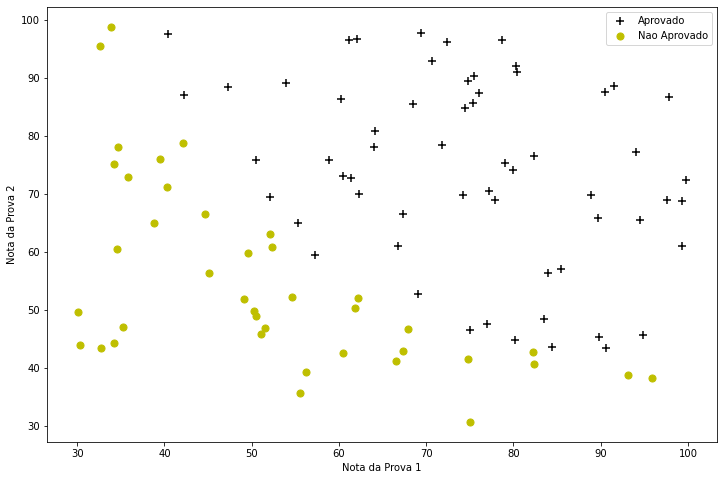

In [56]:
# Visualização dos dados - gráfico de dispersão
plot(data)

### 1.2.2. Ajuste dos modelos & 1.2.3. Avaliação dos modelos

**Observação importante**: as seções 1.2.2. e 1.2.3. serão realizadas conjuntamente para melhor compreensão dos resultados.

**Objetivo da questão 1.2.2.**

* Ajustar diversos modelos de classificação que fornecem uma estimativa da probabilidade de admissão de um candidato, com base nas notas que ele obteve nas 2 avaliações.

**Objetivo da questão 1.2.3.**

* Avaliar a qualidade de generalização de cada modelo.

* Utilizar 20% dos exemplos contidos no conjunto de dados fornecidos para compor o conjunto de teste.

* Apresentar a matriz de confusão para cada classificador criado.

* Apresentar os resultados obtidos por meio da função `classification_report` do `Scikit-Learn`.

**Divisão do dataset original em conjuntos de treino e de teste**

Semelhante ao desenvolvimento do item 1.1., para esta questão foi utilizado o método *Two-way holdout* para separação do dataset original. Para este fim, foi utilizada a classe `train_test_split` do Scikit-Learn. Portanto, a partir de uma matriz de dados ($\mathrm{X}$) e um vetor de resposta ($\mathrm{y}$), o `train_test_split` retorna com 2 matrizes de dados ($\mathrm{X_{train}}$ e $\mathrm{X_{test}}$) e 2 vetores de resposta ($\mathrm{y_{train}}$ e $\mathrm{y_{test}}$). Por fim, foi utilizada a proporção de 70% do dataset original para o conjunto de treino e 30% para o conjunto de teste.

In [57]:
# Divisão do conjunto de dados em 2 subconjuntos (treino e teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 31)

# Argumentos da função "train_test_split"
# 1º argumento: X => matrizes de dados
# 2º argumento: y => vetor de resposta
# 3º argumento: test_size => % do conjunto de dados que ficará no conjunto de treino e que ficará no conjunto de teste
# 4º argumento: random_state => garante que o mesmo split seja feito (utilizando o mesmo conjunto de dados)
# obs.: random_state é utilizado para garantir reprodutibilidade do modelo
# 5º parâmetro: stratify=y => assegura proporções similares dos conjuntos de dados de treino e de teste (das classes)

**Normalização das características**

Conforme argumentado na questão 1.1.2, a abordagem indicada para lidar com as diferenças nas escalas de medidas dos atributos é a normalização das características. Uma das técnicas de normalização das características é a padronização (terminologia retirada da estatística), que corresponde à transformação do atributo em uma variável normal padrão (com $\mu = 0$ e $\sigma = 1$). Diante disso, é possível representar esta técnica por meio da seguinte expressão:

$$
Z_i = \frac{X_i - \mu_i}{\sigma_i}
$$

onde $X_i$ é o atributo $i$ da matriz de dados, $\mu_i$ e $\sigma_i$ são a média e o desvio padrão de $X_i$, respectivamente. Por fim, $X_i \sim N(\mu_i,\sigma_i)$ e $Z_i \sim N(0,1)$. Portanto, o resultado da padronização é um conjunto de atributos com média zero e desvio padrão 1. Em outras palavras, a padronização assume que as features se ajustam a uma distribuição Gaussiana (distribuitção normal).

A classe `StandardScaler` do Scikit-Learn é utilizada para lidar com as diferenças de ordens de grandezas entre as features. Assim, a utilização desta classe permite que as features tenham ordens de grandeza similares.

O `StandardScaler` calcula a média e o desvio padrão de cada coluna do dataset e depois realiza a subtração de cada valor pela média calculada e a divisão do resultado da subtração pelo desvio padrão calculado. Contudo, antes de aplicar o `StandardScaler` aos dados de treino e de teste, é preciso ajustá-lo ao conjunto de treinamento. Essa prática evita que qualquer informação do conjunto de teste seja vista pelo conjunto de treinamento.

In [58]:
# Criação do objeto para a padronização das features
class_scaler = StandardScaler()

# Ajustamento do StandardScaler ao conjunto de dados de treino e padronização dos dados de treino
X_train_norm = class_scaler.fit_transform(X_train)    

# class_scaler.fit(X_train) => ajusta os parâmetros para padronização a partir dos dados de treino
# class_scaler.fit(X_train) => Cálculo da média e do desvio padrão que serão utilizados para padronização das features
# class_scaler.transform(X_train) => padronização dos dados de treino
# "class_scaler.fit_transform(X_train)" corresponde a "rm_scaler.fit(X_train)" e "rm_scaler.transform(X_train)"

# Transformação dos dados de teste com os parâmetros ajustados a partir dos dados de treino
X_test_norm = class_scaler.transform(X_test)

**(a) Algoritmo Naive Bayes**

**Aspectos conceituais**

O Naive Bayes é um tipo de classificador baseado na aplicação do teorema de Bayes utilizado para calcular a probabilidade de que um exemplo pertencente à matriz de dados $\mathrm{X}$ pertença a uma determinada classe. 

Seja $\left \{x_1, x_2, \dots, x_n\right \}$ o conjunto de atributos na matriz de dados $\mathrm{X}$, o classificador Bayesiano atribui cada atributo a uma das $i$-ésimas classes do vetor de resposta $\mathrm{y}$. Esta atribuição é feita com base na probabilidade dos atributos $\left \{x_1, x_2, \dots, x_n\right \}$ pertencerem à classe $c_i$. Em outras palavras, $\left \{x_1, x_2, \dots, x_n\right \}$ são atribuídos à classe $c_i$ se, e somente se, $\Pr(y = c_i \mid x_1, x_2, \dots, x_n) > \Pr(y = c_j \mid x_1, x_2, \dots, x_n)$, para todo $j$, tal que $1 \leq j \leq m$.

$$
\Pr(y = c_i \mid x_1, x_2, \dots, x_n) = \frac{\Pr (y = c_i) \Pr (x_1, x_2, \dots x_n \mid y = c_i)} {\Pr(x_1, x_2, \dots, x_n)}
$$

Visto que Naive Bayes assume que, para cada classe, os atributos são estatisticamente independentes, é possível escrever as probabilidades condicionais de forma simplificada conforme a expressão abaixo:

$$
\Pr(x_1, x_2, \dots x_n \mid y = c_i) = \Pr(x_1 \mid y = c_i) \times \Pr(x_2 \mid y = c_i) \times \ldots \times \Pr(x_n \mid y = c_i) = \coprod^{n}_{k=1}\Pr{(x_k \mid y = c_i)}
$$

Por fim, assumindo que a hipótese naive seja verdadeira, a fórmula do teorema de Bayes pode ser simplificada:

$$
\Pr(y = c_i \mid x_1, x_2, \dots, x_n) \propto \coprod^{n}_{k=1}\Pr{(x_k \mid y = c_i)}
$$

É possível aplicar o algoritmo Naive Bayes para features preditivas contínuas por meio da implementação da classe `GaussianNB` (presumindo que cada feature possui aproximadamente uma distribuição normal).

**Versão Vanilla (sem otimização dos hiperparâmetros)**

In [59]:
# Criação do objeto de classificação
modelNB_vanilla = GaussianNB()

In [60]:
# Ajustamento do modelo ao conjunto de treinamento (treinamento do modelo)
modelNB_vanilla.fit(X_train_norm, y_train)

GaussianNB()

In [61]:
# Predição do modelo sobre o conjunto de teste (previsão das classes de exemplos que não foram vistos na etapa de treinamento)
y_pred_NB_vanilla = modelNB_vanilla.predict(X_test_norm)

Acurácia do modelo Naive Bayes Gaussiano (em %): 0.85


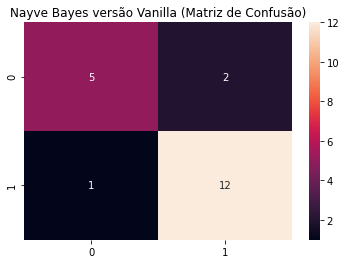

In [62]:
# Avaliação do modelo Naive Bayes versão Vanilla
# Comparação entre os valores de resposta observados (y_test) e os valores de resposta preditos (y_pred_NB_vanilla)
print("Acurácia do modelo Naive Bayes Gaussiano (em %): {}".format(accuracy_score(y_test, y_pred_NB_vanilla)))
confusion_matrix_NB_vanilla = confusion_matrix(y_test, y_pred_NB_vanilla)
sns.heatmap(confusion_matrix_NB_vanilla, annot = True)
plt.title('Nayve Bayes versão Vanilla (Matriz de Confusão)')
plt.show()

In [63]:
# Apresentação dos resultados
print(classification_report(y_test, y_pred_NB_vanilla))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.86      0.92      0.89        13

    accuracy                           0.85        20
   macro avg       0.85      0.82      0.83        20
weighted avg       0.85      0.85      0.85        20



**Versão com otimização dos hiperparâmetros**

In [64]:
# Criação do objeto de classificação
modelNB_optimal = GaussianNB()

In [65]:
# Definição da pré-configuração dos parâmetros para a otmimização do hiperparâmetro
NB_class_param = {'var_smoothing': np.logspace(0, -9, num = 100)}

# var_smoothing: parte da maior variação de todos os recursos que é adicionada às variações para estabilidade do cálculo. 
# O valor default do argumento `var_smoothing` é 1e-9. O *random search* é conduzido na escala logarítmica (`logspace`).

In [66]:
# Busca randomizada da combinação dos hiperparâmetros
NB_class_random_search = RandomizedSearchCV(modelNB_optimal,
                                            NB_class_param,
                                            n_iter = 20,
                                            cv = 10,
                                            scoring = 'neg_mean_squared_error')

# 1º argumento: modelo para o qual desejamos otimizar os parâmetros (modelKNN_rs)
# 2º argumento: vetor de parâmetros utilizados que serão otimizados (KNN_rs_param)
# 3º argumento: nº de configurações de parâmetros que são testadas  (n_iter). O default é "n_iter = 10".
# 4º argumento: gerador de validação cruzada (cv) => quantidade de folds
# 5º argumento: estratégia para avaliar o desempenho do modelo com validação cruzada no conjunto de teste (scoring)

In [67]:
# Treinamento do modelo usando as combinações aleatórias de hiperparâmetros geradas pelo RandomizedSearchCV
NB_class_random_search.fit(X_train_norm, y_train)

RandomizedSearchCV(cv=10, estimator=GaussianNB(), n_iter=20,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.511191...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   scoring='neg_mean_squared_error')

In [68]:
# Identificação do hiperparâmetro ótimo
NB_class = NB_class_random_search.best_params_['var_smoothing']
print("Valor do hiperparâmetro ótimo: {:.2f}".format(NB_class))

Valor do hiperparâmetro ótimo: 0.66


In [69]:
# Predição dos valores dos exemplos que não foram vistos na etapa de treinamento
modelNB_class_best = NB_class_random_search.best_estimator_
y_pred_NB_optimal = modelNB_class_best.predict(X_test_norm)

Acurácia do modelo Naive Bayes Gaussiano (em %): 0.9


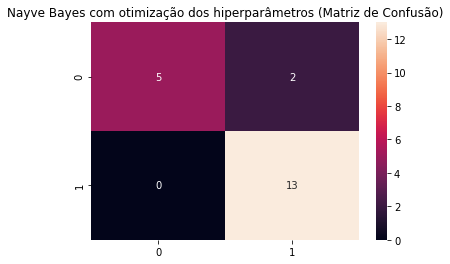

In [70]:
# Avaliação do modelo Naive Bayes com otimizador de hiperparâmetros
# Comparação entre os valores de resposta observados (y_test) e os valores de resposta preditos (y_pred_NB_optimal)
print("Acurácia do modelo Naive Bayes Gaussiano (em %): {}".format(accuracy_score(y_test, y_pred_NB_optimal)))
confusion_matrix_NB_optimal = confusion_matrix(y_test, y_pred_NB_optimal)
sns.heatmap(confusion_matrix_NB_optimal, annot = True)
plt.title('Nayve Bayes com otimização dos hiperparâmetros (Matriz de Confusão)')
plt.show()

In [71]:
# Apresentação dos resultados
print(classification_report(y_test, y_pred_NB_optimal))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.87      1.00      0.93        13

    accuracy                           0.90        20
   macro avg       0.93      0.86      0.88        20
weighted avg       0.91      0.90      0.90        20



Pelos resultados obtidos para o algoritmo Naive Bayes nas 2 versões analisadas é possível observar que a versão com otimização de hiperparâmetros apresentou melhor desempenho. Enquanto que a versão Vanilla apresentou uma acurácia de 0.85, a versão considerando a otimização dos hiperparâmetros apresentou uma acurácia de 0.90.

Visto que a acurácia não é uma métrica de avaliação adequada para um dataset desbalanceado é possível analisar o desempenho comparativo dos modelos pela métrica F1. Enquanto que a versão Vanilla apresentou F1 de 0.77 para a classe 0 e 0.89 para a classe 1, a versão com otimização de parâmetros apresentou F1 de 0.83 para a classe 0 e 0.93 para a classe 1. Portanto, este resultado corrobora a conclusão de que a versão considerando a otimização dos hiperparâmetros apresentou melhor desempenho do que a versão Vanilla.

**(b) Algoritmo Regressão Logística**

**Aspectos conceituais**

Conforme visto no trabalho 1, a regressão logística permite prever a probabilidade de que um exemplo pertença uma determinada classe. Além disso, um modelo linear é incluído em uma função logistica (função sigmoide), de modo que o output da função seja restrito a um intervalo entre zero e 1, de modo que tal valor possa ser interpretado como uma probabilidade.

A classe `LogisticRegression` do Scikit-Learn implementa a regressão logística.

**Versão Vanilla (sem otimização dos hiperparâmetros)**

In [72]:
# Criação do objeto de classificação
modelRegLog_vanilla = LogisticRegression()

# default, solver = 'lbfgs'
# solver: minimizador do sklearn
# lbfgs: solver baseado em método de newton (alternativa ao Gradiente Descendente)
# default, penalty = l2

In [73]:
# Ajustamento do modelo ao conjunto de treinamento (treinamento do modelo)
modelRegLog_vanilla.fit(X_train_norm, y_train)

LogisticRegression()

In [74]:
# Predição do modelo sobre o conjunto de teste (previsão das classes de exemplos que não foram vistos na etapa de treinamento)
y_pred_RegLog_vanilla = modelRegLog_vanilla.predict(X_test_norm)

Acurácia do modelo de Regressão Logística (em %): 0.8


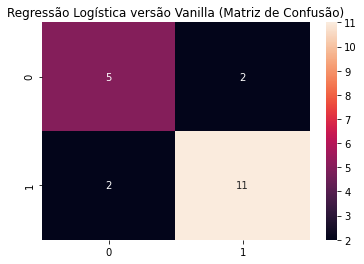

In [75]:
# Avaliação do modelo de Regressão Logística versão Vanilla
# Comparação entre os valores de resposta observados (y_test) e os valores de resposta preditos (y_pred_RegLog_vanilla)
print("Acurácia do modelo de Regressão Logística (em %): {}".format(accuracy_score(y_test, y_pred_RegLog_vanilla)))
confusion_matrix_RegLog_vanilla = confusion_matrix(y_test, y_pred_RegLog_vanilla)
sns.heatmap(confusion_matrix_RegLog_vanilla, annot = True)
plt.title('Regressão Logística versão Vanilla (Matriz de Confusão)')
plt.show()

In [76]:
# Apresentação dos resultados
print(classification_report(y_test, y_pred_RegLog_vanilla))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.85      0.85      0.85        13

    accuracy                           0.80        20
   macro avg       0.78      0.78      0.78        20
weighted avg       0.80      0.80      0.80        20



**Versão com otimização dos hiperparãmetros**

In [77]:
# Criação do objeto de classificação
modelRegLog_optimal = LogisticRegression(max_iter = 200, random_state = 0)

In [78]:
# Definição da pré-configuração dos parâmetros para a otmimização do hiperparâmetro
RegLog_class_param = {'penalty': ['l1', 'l2', 'elasticnet'],
                      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [79]:
# Busca randomizada da combinação dos hiperparâmetros
LogReg_class_random_search = RandomizedSearchCV(modelRegLog_optimal,
                                                RegLog_class_param,
                                                n_iter = 20,
                                                cv = 10,
                                                scoring = 'neg_mean_squared_error')

# 1º argumento: modelo para o qual desejamos otimizar os parâmetros (modelKNN_rs)
# 2º argumento: vetor de parâmetros utilizados que serão otimizados (KNN_rs_param)
# 3º argumento: nº de configurações de parâmetros que são testadas  (n_iter). O default é "n_iter = 10".
# 4º argumento: gerador de validação cruzada (cv) => quantidade de folds
# 5º argumento: estratégia para avaliar o desempenho do modelo com validação cruzada no conjunto de teste (scoring)

In [80]:
# Treinamento do modelo usando as combinações aleatórias de hiperparâmetros geradas pelo RandomizedSearchCV
LogReg_class_random_search.fit(X_train_norm, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 15 is smaller than n_iter=20. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalt

RandomizedSearchCV(cv=10,
                   estimator=LogisticRegression(max_iter=200, random_state=0),
                   n_iter=20,
                   param_distributions={'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   scoring='neg_mean_squared_error')

In [81]:
# Identificação do hiperparâmetro ótimo
LogReg_class1 = LogReg_class_random_search.best_params_['penalty']
print("Valor do hiperparâmetro ótimo: {}".format(LogReg_class1))

Valor do hiperparâmetro ótimo: l1


In [82]:
# Identificação do hiperparâmetro ótimo
LogReg_class2 = LogReg_class_random_search.best_params_['solver']
print("Valor do hiperparâmetro ótimo: {}".format(LogReg_class2))

Valor do hiperparâmetro ótimo: saga


In [83]:
# Predição dos valores dos exemplos que não foram vistos na etapa de treinamento
modelLogReg_class_best = LogReg_class_random_search.best_estimator_
y_pred_RegLog_optimal = modelLogReg_class_best.predict(X_test_norm)

Acurácia do modelo de Regressão Logística (em %): 0.85


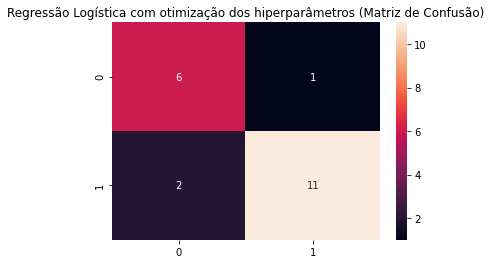

In [84]:
# Avaliação do modelo de Regressão Logística com otimizador de hiperparâmetros
# Comparação entre os valores de resposta observados (y_test) e os valores de resposta preditos (y_pred_RegLog_optimal)
print("Acurácia do modelo de Regressão Logística (em %): {}".format(accuracy_score(y_test, y_pred_RegLog_optimal)))
confusion_matrix_RegLog_optimal =confusion_matrix(y_test, y_pred_RegLog_optimal)
sns.heatmap(confusion_matrix_RegLog_optimal, annot = True)
plt.title('Regressão Logística com otimização dos hiperparâmetros (Matriz de Confusão)')
plt.show()

In [85]:
# Apresentação dos resultados
print(classification_report(y_test, y_pred_RegLog_optimal))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.92      0.85      0.88        13

    accuracy                           0.85        20
   macro avg       0.83      0.85      0.84        20
weighted avg       0.86      0.85      0.85        20



Peloa resultados obtidos para o algoritmo de Regressão Logística nas 2 versões analisadas é possível observar que a versão com otimização de hiperparâmetros apresentou melhor desempenho. Enquanto que a versão Vanilla apresentou uma acurácia de 0.80, a versão considerando a otimização dos hiperparâmetros apresentou uma acurácia de 0.85.

Visto que a acurácia não é uma métrica de avaliação adequada para um dataset desbalanceado é possível analisar o desempenho comparativo dos modelos pela métrica F1. Enquanto que a versão Vanilla apresentou F1 de 0.71 para a classe 0 e 0.85 para a classe 1, a versão com otimização de parâmetros apresentou F1 de 0.80 para a classe 0 e 0.88 para a classe 1. Portanto, este resultado corrobora a conclusão de que a versão considerando a otimização dos hiperparâmetros apresentou melhor desempenho do que a versão Vanilla.

**(c) Algoritmo k-NN**

**Aspectos conceituais**

O classificador k-NN é um classificador baseado em distância. Para realizar uma predição apara um novo ponto de dado, o algoritmo encontra os pontos de dados que estão mais próximos dentro do dataset de treinamento. Em outras palavras, dada uma observação $x_u$, com uma classe alvo desconhecida, o algoritmo primeiro identifica as $k$ observações mais próximas com base em alguma métrica de distância.

A classe `KNeighborsClassifier` implementa o algoritmo k-NN para tarefas de classificação.

**Versão Vanilla (sem otimização dos hiperparâmetros)**

In [86]:
# Criação do objeto de classificação
modelKNN_vanilla = KNeighborsClassifier()

In [87]:
# Ajustamento do modelo ao conjunto de treinamento (treinamento do modelo)
modelKNN_vanilla.fit(X_train_norm, y_train)

KNeighborsClassifier()

In [88]:
# Predição do modelo sobre o conjunto de teste (previsão das classes de exemplos que não foram vistos na etapa de treinamento)
y_pred_KNN_vanilla = modelKNN_vanilla.predict(X_test_norm)

Acurácia do modelo k-NN (em %): 0.8


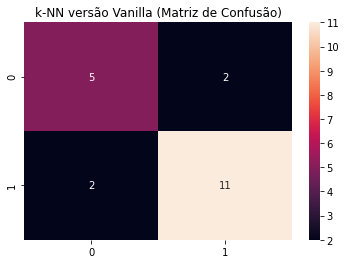

In [89]:
# Avaliação do modelo k-NN versão Vanilla
# Comparação entre os valores de resposta observados (y_test) e os valores de resposta preditos (y_pred_KNN_vanilla)
print("Acurácia do modelo k-NN (em %): {}".format(accuracy_score(y_test, y_pred_KNN_vanilla)))
confusion_matrix_KNN_vanilla = metrics.confusion_matrix(y_test, y_pred_KNN_vanilla)
sns.heatmap(confusion_matrix_KNN_vanilla, annot = True)
plt.title('k-NN versão Vanilla (Matriz de Confusão)')
plt.show()

In [90]:
# Apresentação dos resultados
print(classification_report(y_test, y_pred_KNN_vanilla))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.85      0.85      0.85        13

    accuracy                           0.80        20
   macro avg       0.78      0.78      0.78        20
weighted avg       0.80      0.80      0.80        20



**Versão com otimização dos hiperparãmetros**

In [91]:
# Criação do objeto de regressão (sem a definição arbitrária do valor do hiperparâmetro k)
modelKNN_optimal = KNeighborsClassifier(weights = 'distance')

# por default, o algoritmo utiliza "p = 2" (distância euclidiana)
# Argumento "weights": função de peso utilizada na predição.
# weights = ‘distance’ => os pesos dos pontos de dados são obtidos pela inversa da suas distâncias.

In [92]:
# Definição do intervalo pré-configurado para a sintonização do hiperparâmetro k
KNN_class_param = {'n_neighbors': list(range(1, 30)),
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# n_neighbors: nº de vizinhos (hiperparâmetro k do k-NN)
# algorithm: algoritmo utilizado para calcular os vizinhos mais próximos

In [93]:
# Busca randomizada da combinação dos hiperparâmetros
KNN_class_random_search = RandomizedSearchCV(modelKNN_optimal,
                                             KNN_class_param,
                                             n_iter = 20,
                                             cv = 10,
                                             scoring = 'neg_mean_squared_error')

# 1º argumento: modelo para o qual desejamos otimizar os parâmetros (modelKNN_rs)
# 2º argumento: vetor de parâmetros utilizados que serão otimizados (KNN_rs_param)
# 3º argumento: nº de configurações de parâmetros que são testadas  (n_iter). O default é "n_iter = 10".
# 4º argumento: gerador de validação cruzada (cv) => quantidade de folds
# 5º argumento: estratégia para avaliar o desempenho do modelo com validação cruzada no conjunto de teste (scoring)

In [94]:
# Treinamento do modelo usando as combinações aleatórias de hiperparâmetros geradas pelo RandomizedSearchCV
KNN_class_random_search.fit(X_train_norm, y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(weights='distance'),
                   n_iter=20,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29]},
                   scoring='neg_mean_squared_error')

In [95]:
# Identificação do hiperparâmetro ótimo
KNN_class1 = KNN_class_random_search.best_params_['n_neighbors']
print("Valor do hiperparâmetro ótimo: {:.2f}".format(KNN_class1))

Valor do hiperparâmetro ótimo: 15.00


In [96]:
# Identificação do hiperparâmetro ótimo
KNN_class2 = KNN_class_random_search.best_params_['algorithm']
print("Valor do hiperparâmetro ótimo: {}".format(KNN_class2))

Valor do hiperparâmetro ótimo: kd_tree


In [97]:
# Predição dos valores dos exemplos que não foram vistos na etapa de treinamento
modelKNN_class_best = KNN_class_random_search.best_estimator_
y_pred_KNN_optimal = modelKNN_class_best.predict(X_test_norm)

Acurácia do modelo k-NN (em %): 0.9


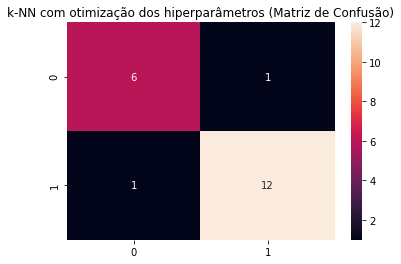

In [98]:
# Avaliação do modelo k-NN com otimização dos hiperparãmetros
# Comparação entre os valores de resposta observados (y_test) e os valores de resposta preditos (y_pred_KNN_optimal)
print("Acurácia do modelo k-NN (em %): {}".format(accuracy_score(y_test, y_pred_KNN_optimal)))
confusion_matrix_KNN_optimal = metrics.confusion_matrix(y_test, y_pred_KNN_optimal)
sns.heatmap(confusion_matrix_KNN_optimal, annot = True)
plt.title('k-NN com otimização dos hiperparâmetros (Matriz de Confusão)')
plt.show()

In [99]:
# Apresentação dos resultados
print(classification_report(y_test, y_pred_KNN_optimal))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.92      0.92      0.92        13

    accuracy                           0.90        20
   macro avg       0.89      0.89      0.89        20
weighted avg       0.90      0.90      0.90        20



Pelos resultados obtidos para o algoritmo k-NN nas 2 versões analisadas é possível observar que a versão com otimização de hiperparâmetros apresentou melhor desempenho. Enquanto que a versão Vanilla apresentou uma acurácia de 0.80, a versão considerando a otimização dos hiperparâmetros apresentou uma acurácia de 0.90.

Visto que a acurácia não é uma métrica de avaliação adequada para um dataset desbalanceado é possível analisar o desempenho comparativo dos modelos pela métrica F1. Enquanto que a versão Vanilla apresentou F1 de 0.71 para a classe 0 e 0.85 para a classe 1, a versão com otimização de parâmetros apresentou F1 de 0.86 para a classe 0 e 0.92 para a classe 1. Portanto, este resultado corrobora a conclusão de que a versão considerando a otimização dos hiperparâmetros apresentou melhor desempenho do que a versão Vanilla.

**(d) Algoritmo de indução de Árvore de Decisão**

**Aspectos conceituais**

O algoritmo de indução de Árvore de Decisão é uma árvore de regras, onde cada nível representa um parâmetro e cada nó do nível valida uma restrição para esse parâmetro do nível e cada galho/ramificação indica um valor possível do parâmetro do nó pai. . Este algoritmo tem como preocupação a busca pela regra de decisão que produz a maior redução de impureza em um nó.

A classe `DecisionTreeClassifier` implementa o algoritmo de indução de Árvores de Decisão para tarefas de classificação.

**Versão Vanilla (sem otimização dos hiperparâmetros)**

In [100]:
# Criação do objeto de classificação
modelDT_vanilla = DecisionTreeClassifier()

In [101]:
# Ajustamento do modelo ao conjunto de treinamento (treinamento do modelo)
modelDT_vanilla.fit(X_train_norm, y_train)

DecisionTreeClassifier()

In [102]:
# Predição do modelo sobre o conjunto de teste (previsão das classes de exemplos que não foram vistos na etapa de treinamento)
y_pred_DT_vanilla = modelDT_vanilla.predict(X_test_norm)

Acurácia do modelo Decision Tree (em %): 0.9


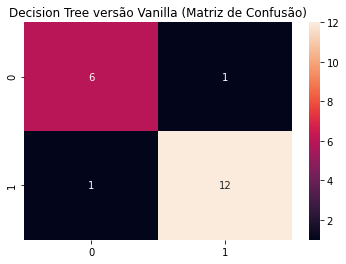

In [103]:
# Avaliação do modelo Decision Tree versão Vanilla
# Comparação entre os valores de resposta observados (y_test) e os valores de resposta preditos (y_pred_DT_vanilla)
print("Acurácia do modelo Decision Tree (em %): {}".format(metrics.accuracy_score(y_test, y_pred_DT_vanilla)))
confusion_matrix_DT_vanilla = metrics.confusion_matrix(y_test, y_pred_DT_vanilla)
sns.heatmap(confusion_matrix_DT_vanilla, annot = True)
plt.title('Decision Tree versão Vanilla (Matriz de Confusão)')
plt.show()

In [104]:
# Apresentação dos resultados
print(classification_report(y_test, y_pred_DT_vanilla))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.92      0.92      0.92        13

    accuracy                           0.90        20
   macro avg       0.89      0.89      0.89        20
weighted avg       0.90      0.90      0.90        20



**Versão com otimização dos hiperparâmetros**

In [105]:
# Criação do objeto de classificação
modelDT_optimal = DecisionTreeClassifier()

In [106]:
# Definição do intervalo pré-configurado para a sintonização do hiperparâmetro "max_depth"
DT_class_param = {'max_depth': [None] + list(range(2, 30)),
                  'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random']}

# Argumento "max_depth": altura máxima da árvore que será induzida
# Argumento "criterion": medida da qualidade da divisão
# Argumento "splitter": estratégia utilizada para dividir cada nó

In [107]:
# Busca randomizada da combinação dos hiperparâmetros
DT_class_random_search = RandomizedSearchCV(modelDT_optimal,
                                            DT_class_param,
                                            n_iter = 20,
                                            cv = 10,
                                            scoring = 'neg_mean_squared_error')

# 1º argumento: modelo para o qual desejamos otimizar os parâmetros (modelDT_rs)
# 2º argumento: vetor de parâmetros utilizados que serão otimizados (DT_rs_param)
# 3º argumento: nº de configurações de parâmetros que são testadas  (n_iter). O padrão é "n_iter = 10".
# 4º argumento: gerador de validação cruzada (cv)
# 5º argumento: estratégia para avaliar o desempenho do modelo com validação cruzada no conjunto de teste (scoring)

In [108]:
# Treinamento do modelo usando as combinações aleatórias de hiperparâmetros geradas pelo RandomizedSearchCV
DT_class_random_search.fit(X_train_norm, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29],
                                        'splitter': ['best', 'random']},
                   scoring='neg_mean_squared_error')

In [109]:
# Identificação do hiperparâmetro ótimo
DT_class1 = DT_class_random_search.best_params_['max_depth']
print("Valor do hiperparâmetro ótimo: {:.2f}".format(DT_class1))

Valor do hiperparâmetro ótimo: 16.00


In [110]:
# Identificação do hiperparâmetro ótimo
DT_class2 = DT_class_random_search.best_params_['criterion']
print("Valor do hiperparâmetro ótimo: {}".format(DT_class2))

Valor do hiperparâmetro ótimo: gini


In [111]:
# Identificação do hiperparâmetro ótimo
DT_class3 = DT_class_random_search.best_params_['splitter']
print("Valor do hiperparâmetro ótimo: {}".format(DT_class3))

Valor do hiperparâmetro ótimo: best


In [112]:
# Predição dos valores dos exemplos que não foram vistos na etapa de treinamento
modelDT_class_best = DT_class_random_search.best_estimator_
y_pred_DT_optimal = modelDT_class_best.predict(X_test_norm)

Acurácia do modeloDecision Tree (em %): 0.9


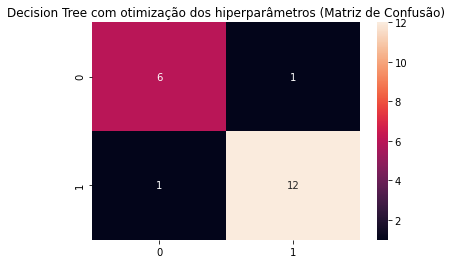

In [113]:
# Avaliação do modelo Decision Tree com otimizador de hiperparâmetros
# Comparação entre os valores de resposta observados (y_test) e os valores de resposta preditos (y_pred_DT_optimal)
print("Acurácia do modeloDecision Tree (em %): {}".format(metrics.accuracy_score(y_test, y_pred_DT_optimal)))
confusion_matrix_DT_optimal = metrics.confusion_matrix(y_test, y_pred_DT_optimal)
sns.heatmap(confusion_matrix_DT_optimal, annot = True)
plt.title('Decision Tree com otimização dos hiperparâmetros (Matriz de Confusão)')
plt.show()

In [114]:
# Apresentação dos resultados
print(classification_report(y_test, y_pred_DT_optimal))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.92      0.92      0.92        13

    accuracy                           0.90        20
   macro avg       0.89      0.89      0.89        20
weighted avg       0.90      0.90      0.90        20



Peloa resultados obtidos para o algoritmo Decision Tree nas 2 versões analisadas é possível observar ambas as versões apresentam o mesmo desempenho, visto que independentemente da versão a acurácia foi igual a 0.90.

Visto que a acurácia não é uma métrica de avaliação adequada para um dataset desbalanceado é possível analisar o desempenho comparativo dos modelos pela métrica F1. Semelhante ao resultado observado pela acurácia, o F1 para a classe 0 e o F1 para a classe 1 também deram valores semelhantes. Diante disso, não foi possível identificar qual foi o melhor modelo.

**Discussão**

Conforme visto anteriormente, as versões com otimização dos hiperparâmetros apresentaram desempenho superior às versões Vanilla (com exceção do Decision Tree, onde ambas as versões apresentaram o mesmos desempenho).

A partir das versões com otimização dos hiperparâmetros, é possível realizar uma análise comparativa entre as métricas de avaliação dos modelos de classificação vistos anteriormente:

| Modelo | Acurácia | F1 - Classe 0 | F1 - Classe 1 |
| :---: | :---: | :---: | :---: |
| Naive Bayes | 0.90 | 0.83 | 0.93 |
| Regressão Logística | 0.85 | 0.80 | 0.88 | 
| k-NN | 0.90 | 0.86 | 0.92 |
| Decision Tree | 0.90 | 0.86 | 0.92 |

O modelo de Regressão Logística foi o único que apresentou menor acurácia. No geral, tanto o k-NN quanto o Decision Tree apresentaram melhor desempenho entre os modelos analisados.

### 1.2.4. Mapeamento das características

**Objetivos da questão**

* Utilizar a classe `PolynomialFeatures` do Scikit-Learn.

* Mapear cada exemplo $x$ do conjunto de dados original para um espaço de dimensionalidade maior.

* Utilizar a classe `LogisticRegression` para induzir um classificador sobre o novo conjunto de treinamento.

**Aspectos conceituais**

Como observado no gráfico da seção 1.2.1, o conjunto de dados possui uma conformação não linear. Contudo, um modelo linear torna-se não adequado para o ajustamento ao conjunto de dados e, consequentemente, para esboçar uma fronteira de decisão capaz de separar os exemplos pertencentes a diferentes classes. Diante disso, uma estratégia utilizada para melhorar o desempenho do modelo é a criação de novas features por meio da geração de features polinomiais.

A classe `PolynomialFeatures` do Scikit-Learn gera features polinomiais e de iteração, por meio da geração de uma nova matriz de features contendo todas as combinações polinomiais (até o grau polinomial especificado).

In [115]:
# Mapeamento das características
poly_features = PolynomialFeatures(6)    # criação do objeto para o mapeamento
X_poly = poly_features.fit_transform(X)  # transformação da matriz de dados original

In [116]:
# Dimensão da matriz de dados original (100 linhas e 2 colunas)
print('Dimensão da matriz de dados original: {}'.format(X.shape))

# Nova dimensão da matriz de dados (100 linhas e 28 colunas)
print('Dimensão da nova matriz de dados: {}'.format(X_poly.shape))

Dimensão da matriz de dados original: (100, 2)
Dimensão da nova matriz de dados: (100, 28)


**Indução do classificador de regressão logística sobre o novo conjunto de treinamento**

In [117]:
# Divisão do conjunto de dados em 2 subconjuntos (treino e teste)
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y,
                                                              test_size = 0.2, 
                                                              random_state = 31)

In [118]:
# Aplicação do algoritmo de regressão logística sobre o novo conjunto de dados
modelLogReg_poly = LogisticRegression()
modelLogReg_poly.fit(X_train_poly, y_train)

LogisticRegression()

### 1.2.5. Esboço da fronteira de decisão

**Aspectos conceituais**

A fronteira de decisão visa separar os exemplos de classes diferentes em cada lado da fronteira.

A função `plotFronteira` esboça a fronteira de decisão utilizando o conjunto de dados derivado da transformação polinominal ocorrida na seção 1.2.4.

In [119]:
def plotFronteira(data, model, filename = 'target/plot.png'):
  
  ##PREPARAÇÃO DA FRONTEIRA DE DECISÃO
  #Cria dados com valores contidos nos limites do conjunto de dados original
  i = min(data.iloc[:, 0]) - 5
  s = max(data.iloc[:, 0]) + 5
  xx, yy = np.mgrid[i:s:.1, i:s:.1]
  grid = np.c_[xx.ravel(), yy.ravel()]

  #Realiza a transformação polinomial dos dados gerados
  grid_poly = poly_features.fit_transform(grid)
  #Calcula a probabilidade das classes
  probs = model.predict_proba(grid_poly)[:, 1].reshape(xx.shape)

  ##GERAÇÃO DO GRÁFICO DE DISPERSÃO
  #Separação dos valores das classes
  positivo = data[data['Aprovado'].isin([1])]
  negativo = data[data['Aprovado'].isin([0])]

  #Gerando o grafico de dispersao para analise preliminar dos dados
  fig, ax = plt.subplots(figsize=(12,8))

  ax.scatter(positivo['Prova 1'], positivo['Prova 2'],
             s=50, c='k', marker='+', label='Aprovado')
  
  ax.scatter(negativo['Prova 1'], negativo['Prova 2'],
             s=50, c='y', marker='o', label='Nao Aprovado')
  
  ##PLOTAGEM DA FRONTEIRA DE DECISÃO
  ax.contour(xx, yy, probs, levels=[0.5],
             colors=['r'])
  
  ##CONFIGURAÇÕES VISUAIS ADICIONAIS
  ax.legend()

  ax.set_xlabel('Nota da Prova 1')
  ax.set_ylabel('Nota da Prova 2')
  sns.despine()

  ##GRAVAÇÃO DO RESULTADO
  if not os.path.exists(os.path.dirname(filename)):
    os.makedirs(os.path.dirname(filename))
  
  plt.savefig(filename)
  plt.show()

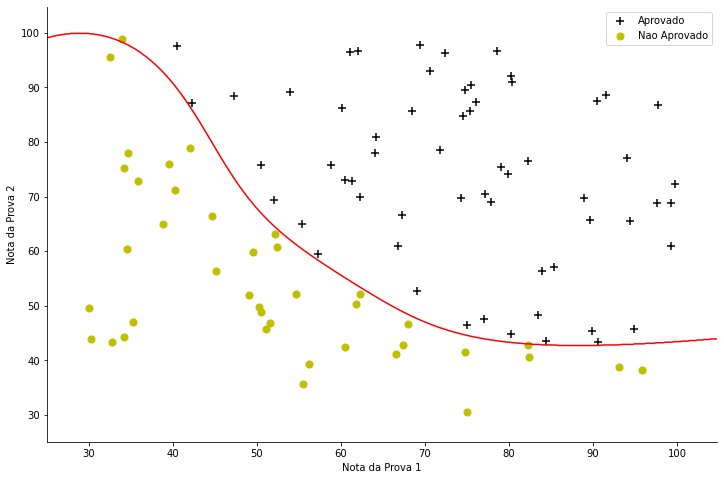

In [120]:
filename='target/plot1.2.5.1.png'
model = modelLogReg_poly
plotFronteira(data, model, filename)

## 1.3. Regularização

**Bibliotecas necessárias para a resolução da questão 1.3.**

In [121]:
# Leitura de arquivos ".mat"
import scipy.io          
import scipy.io as spio

# Realização de requisições (baixar uma página da web)
import requests          

# Plotar gráficos
import matplotlib.pyplot as plt    
%matplotlib inline

# Implementação de regressão linear (com e sem regularização)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Manipulação de dados tabulares
import numpy as np

# Determinação dos conjuntos de treino e de validação cruzada para plotagem da curva de aprendizado
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Otimização de funções
import scipy.optimize as opt

# Funções do trabalho 1
from utils import custo_reglin_regularizada
from utils import gd_reglin_regularizada

# Mapeamento das características
from sklearn.preprocessing import PolynomialFeatures

# Normalização das característica
from sklearn.preprocessing import StandardScaler   

# Busca de combinação de hiperparãmetro utilizando a abordagem "grid search"
from sklearn.model_selection import GridSearchCV

# Mean squared error regression loss
from sklearn.metrics import mean_squared_error

# Mean absolute error regression loss
from sklearn.metrics import mean_absolute_error

# Coeficiente de determinação
from sklearn.metrics import r2_score

**Dados da questão**

O dataset fornecido pelo arquivo `x5data1.mat` contém registros históricos da mudança no nível da água ($x$) e da quantidade de água que sai da barragem ($y$), e é dividido em 3 partes:

* Conjunto de treinamento que o modelo aprenderá $(\mathrm{X}, \mathrm{y})$.

* Conjunto de validação cruzada para determinação do parâmetro de regularização $(\mathrm{X}_{val}, \mathrm{y}_{val})$.

* Conjunto de testes para avaliação do modelo $(\mathrm{X}_{test}, \mathrm{y}_{test})$.

Os nomes das variáveis contidas no arquivo são: $\mathrm{X}$, $\mathrm{X_{test}}$, $\mathrm{X_{val}}$, $\mathrm{y}$, $\mathrm{y_{test}}$, $\mathrm{y_{val}}$.

**Leitura dos dados**

In [122]:
# Leitura do arquivo
filepath = 'Data/ex5data1.mat'
data = spio.loadmat(filepath, squeeze_me=True)

**Divisão do dataset original em 3 subconjuntos (treino, validação e teste)**:

Este dataset é dividido em 3 partes (adoção do método holdout de 3 vias para a divisão do dataset original):

* Conjunto de treinamento: dados utilizados para ajustamento dos parâmetros para diversos modelos candidatos.

* Conjunto de validação: dados utilizados para ajustar os hiperparâmetros do algoritmo de Aprendizado de Máquinas. O desempenho preditivo sobre este conjunto é utilizado para a seleção do modelo (escolha do melhor modelo candidato).

* Conjunto de teste: dados utilizados para obter uma estimativa do erro de generalização para determinado modelo candidato escolhido.

In [123]:
# Definição dos conjuntos de dadoos
X, y = data['X'].reshape(-1, 1), data['y']                    # conjunto de treinamento
X_val, y_val = data['Xval'].reshape(-1, 1), data['yval']      # conjunto de validação
X_test, y_test = data['Xtest'].reshape(-1, 1), data['ytest']  # conjunto de teste

### 1.3.1. Visualização dos Dados

**Objetivo da questão**

* Produzir uma visualização do conjunto de dados de treinamento.

In [124]:
# Função para plotar gráfico com os dados do conjunto de treino.
def plot_ex5data1(X, y):
    plt.figure(figsize = (10,6))
    plt.xlabel('Mudança no nível da água (x)')
    plt.ylabel('Água saindo da barragem (y)')
    plt.plot(X,y,'rx')

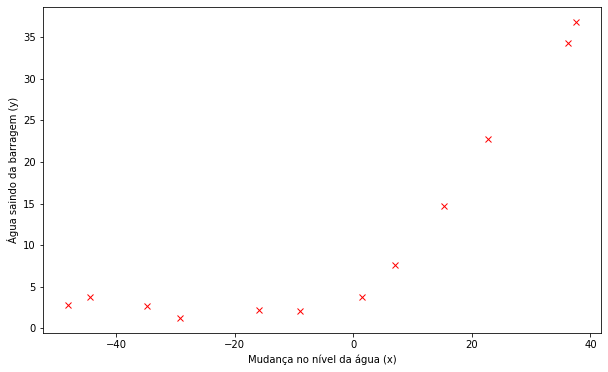

In [125]:
# Gráfico com os dados do conjunto de treino
plot_ex5data1(X, y)

### 1.3.2. Ajuste de um regressor linear

**Objetivos da questão**

* Ajustar um modelo de regressão linear para previsão da quantidade de água que flui de uma barragem, utilizando a mudança do nível da água em um reservatório.

* Utilizar a classe `LinearRegression` do Scikit-Learn.

In [126]:
# Criação do objeto para a regressão linear
modelRegLin = LinearRegression()

In [127]:
# Ajustamento do modelo de regressão linear (treinamento do modelo)
modelRegLin.fit(X, y)

LinearRegression()

In [128]:
#Extrair coeficientes
theta1 = modelRegLin.coef_[0]
theta0 = modelRegLin.intercept_
vector_theta = np.array([theta0, theta1])
print("Vetor de coeficientes estimados: {}".format(vector_theta))

Vetor de coeficientes estimados: [13.08790351  0.36777923]


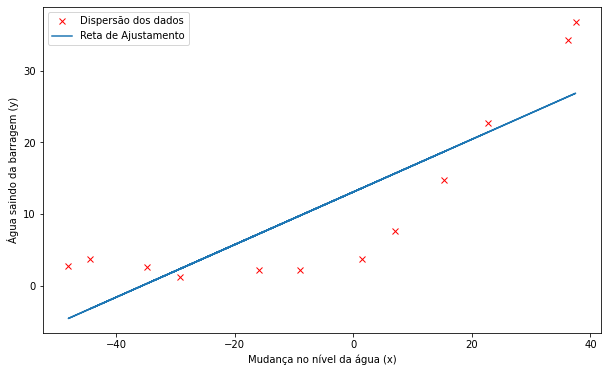

In [129]:
# Gráfico de ajustamento do modelo de regressão linear ao conjunto de dados
plt.figure(figsize = (10,6))
plt.plot(X, y, 'rx')
plt.plot(X, (theta0 + theta1*X))
plt.ylabel('Água saindo da barragem (y)')
plt.xlabel('Mudança no nível da água (x)')
plt.legend(['Dispersão dos dados', 'Reta de Ajustamento'])

O gráfico mostra um possível problema de *underfitting*. O modelo é muito simples para o ajustamento dos dados (baixa variância e elevado viés). Neste caso, é possível observar que a hipótese mapeia mal a tendência dos dados, visto a tentativa de ajustamento de uma reta a uma estrutura de dados curvilínea (o modelo não tem capacidade suficiente para se ajustar à estrutura curvilínea dos dados).

**Avaliação do desempenho do modelo**

In [130]:
# Predição do modelo com valores não observados durante a etapa de treinamento do modelo
y_pred_RegLin = modelRegLin.predict(X_test)

Enquanto o RMSE corresponde a uma medida do desvio médio (ao quadrado) entre o valor observado ($y$) e predito ($\hat{y}$), o coeficiente de determinação ($\mathrm{R}^2$) mede o grau de ajustamento do modelo de regressão ao conjunto de dados (mede o % da variância total nos dados observados que pode ser explicado pelo modelo). Em outras palavras, o $\mathrm{R}^2$ mede quão bem a reta de regressão se ajusta ao conjunto de dados.

Uma medida similar ao RMSE é o MAE (erro médio absoluto), que mede o desvio médio (em termos absolutos) entre o valor observado ($y$) e predito ($\hat{y}$).

In [131]:
# RMSE do modelo de regressão linear
RegLin_rmse = np.sqrt(mean_squared_error(y_test, y_pred_RegLin))
print("RMSE do modelo de Regressão Linear: {:.2f}".format(RegLin_rmse))

RMSE do modelo de Regressão Linear: 8.06


In [132]:
# MAE do modelo de regressão linear 
RegLin_mae = np.sqrt(mean_absolute_error(y_test, y_pred_RegLin))
print("MAE do modelo de Regressão Linear: {:.2f}".format(RegLin_mae))

MAE do modelo de Regressão Linear: 2.41


In [133]:
# Coeficiente de determinação (R2) do modelo de regressão linear (0 <= R2 <= 1)
RegLin_r2 = r2_score(y_test, y_pred_RegLin)
print("Coeficiente de determinação do modelo de Regressão Linear: {:.2f}".format(RegLin_r2))

Coeficiente de determinação do modelo de Regressão Linear: 0.68


### 1.3.3. Curvas de aprendizado

**Objetivos da questão**

* Realizar diagnósticos do modelo linear previamente ajustado.

* Examinar os efeitos do viés e da variância.

* Produzir os gráficos dos erros de treinamento e de teste na forma de curvas de aprendizado para diagnóstico dos problemas de viés-variância.

**Aspectos conceituais**

As curvas de aprendizado visualizam o desempenho de um modelo sobre o conjunto de treinamento e durante a validação cruzada, a medida que o número de observações no conjuntode treinamento aumenta. Elas são comumente utilizadas para determinar se os algoritmos de aprendizado poderiam se beneficiar com a coleta de dados de treinamento adicionais. 

**Observação importante**: Em virtude do fato de a classe `learning_curve` realizar por conta própria a divisão do dataset em treino e validação para comparação dos níveis de erro torna-se necessária a concateção dos subconjuntos de treino e de validação em um único dataset.

In [134]:
# Concatenação dos dados de treino com os dados de validação
X_ = np.concatenate((X, X_val))
y_ = np.concatenate((y, y_val))

# Novas dimensões
print("Nova dimensão da matriz de dados X: {}".format(X_.shape))
print("Nova dimensão do vetor y: {}".format(y_.shape))

Nova dimensão da matriz de dados X: (33, 1)
Nova dimensão do vetor y: (33,)


In [135]:
# Definição dos parâmetros para o esboço das curvas de aprendizado
train_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

sample_example, train_scores, val_scores =  learning_curve(modelRegLin,
                                                            X_, y_,
                                                            scoring = 'neg_mean_squared_error',
                                                            train_sizes = train_sizes)

# Cálculo dos erros baseado na média dos dados de treinamento e validação
train_scores_mean = np.mean(-train_scores, axis = 1)
val_scores_mean = np.mean(-val_scores, axis = 1)

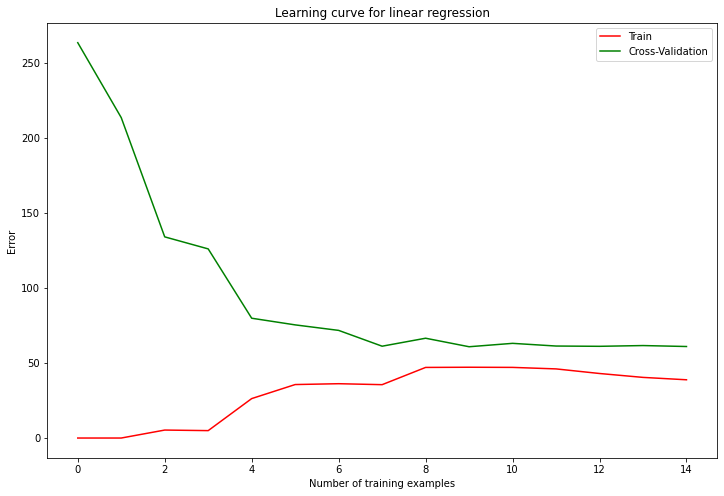

In [136]:
# Esboço das curvas de aprendizado
plt.figure(figsize = (12,8))
plt.plot(train_scores_mean, color = "r")
plt.plot(val_scores_mean, color="g")

plt.title("Learning curve for linear regression")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.legend(['Train', 'Cross-Validation'])

Pelo gráfico acima, é possível observar que o ponto localizado entre 2 e 4 exemplos de treinamento corresponde ao ponto onde o algoritmo está começando a ajustar aos exemplos do conjunto de treinamento. A prtir deste ponto o erro de validação apresenta uma tendência descendente, o erro de treinamento apresenta tendência ascendente. Em ambos os casos, esta tendência é observada até o ponto de 8 exemplos de treinamento.

Em outras palavras, há medida que aumenta o nº de exemplos de treinamento, observa-se aumento do erro de treinamento e diminuição do erro de validação. O erro de validação diminui acentuada até determinado ponto (entre 2 e 4 exemplos de treinamento), após este ponto a curva passa a ter um comportamento mais suavizado. Por outro lado, o erro de treinamento aumenta até determinado ponto (entre 2 e 4 exemplos de treinamento), após este ponto ela começa a decrescer mais suavemente.

O problema com o modelo linear gerado para o conjunto de dados de níveis de água é que esse modelo é muito simples, resultando em *underfitting*.

Para gerar o gráfico semelhante ao enunciado é preciso utilizar as funções para minimização da função de custo do trabalho 1.

In [137]:
def minimizar_funcao(theta, X, y, _lambda):
  """
  Função para aplicação da função de custo e encontrar o vetor otimizado de 
  parâmetros theta
  """
  return opt.fmin_tnc(func = custo_reglin_regularizada,
                      x0=theta, fprime=gd_reglin_regularizada,
                      args=(X, y, _lambda))

In [138]:
def learningCurve(theta, X, y, X_val, y_val, _lambda):
    m = len(X)
    
    train_scores_reg = np.zeros(m)
    val_scores_reg = np.zeros(m)
    sample_example_reg = []
    
    for i in range(1,m+1):
        X_train = X[:i,:]
        y_train = y[:i]
        sample_example_reg.append(len(X_train))
        
        result = minimizar_funcao(theta, X_train, y_train, _lambda)
        theta = result[0]
        
        J_train = custo_reglin_regularizada(theta, X_train, y_train, _lambda = 0)
        J_val = custo_reglin_regularizada(theta, X_val, y_val, _lambda)
        
        train_scores_reg[i-1] = J_train
        val_scores_reg[i-1] = J_val
        
    return sample_example_reg, train_scores_reg, val_scores_reg

In [139]:
# Parâmetros da função
_lambda = 0 #Lambda zerada para não efetuar regularização
theta = np.array([[1,1]]).T #inicialização do vetor theta

#Organização das dimensões dos valores de treino e validação
X_val_ = np.array(data['Xval'], ndmin=2).T
X_val_ = np.c_[np.ones((X_val_.shape[0], 1)), X_val_]
y_val_ = np.array(data['yval'], ndmin=2).T

X_train_ = np.array(data['X'], ndmin=2).T
X_train_ = np.c_[np.ones((X_train_.shape[0], 1)), X_train_]
y_train_ = np.array(data['y'], ndmin=2).T

In [140]:
# Definição da curva de aprendizado
sample_example_reg, train_scores_reg, val_scores_reg = learningCurve(theta,
                                                                     X_train_, y_train_,
                                                                     X_val_, y_val_,
                                                                     _lambda)

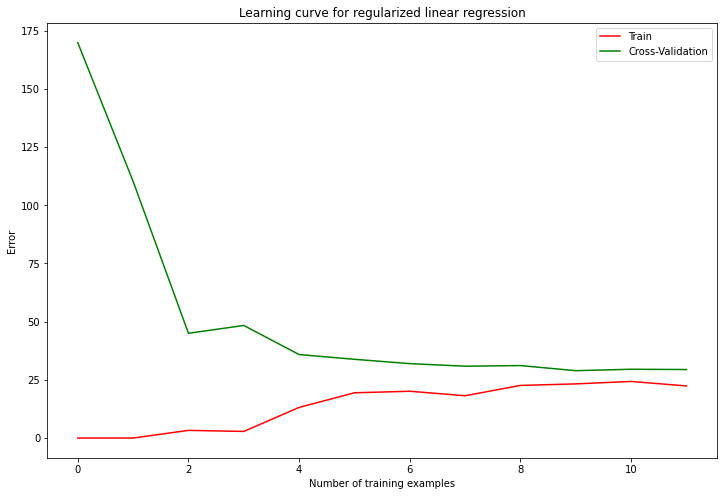

In [141]:
# Esboço da curva de aprendizado
plt.figure(figsize = (12,8))
plt.plot(train_scores_reg, color = "r")
plt.plot(val_scores_reg, color="g")

plt.title("Learning curve for regularized linear regression")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.legend(['Train', 'Cross-Validation'])

Em comparação ao gráfico anterior, é possível observar no gráfico acima que o ponto onde o algoritmo está começando a ajustar aos exemplos do conjunto de treinamento é o mesmo. Por outro lado, no gráfico acima o erro de treinamento continua crescente, enquanto que o erro de validação apresenta um comportamento decrescente. Além disso, os níveis de erro, em ambos os casos são menores.

### 1.3.4. Ajuste de um regressor polinomial não-regularizado

**Objetivo da questão**

* Resolver o problema de subajuste do modelo de regressão linear, adicionando mais caracaterística ao conjunto de dados de treinamento.

* Gerar características adicionais utilizando a classe `PolynomialFeatures` do Scikit-Learn (utilizando polinômio de grau 8).

* Treinar o modelo com o novo conjunto de dados utilizando a implementação da regressão linear fornecida na classe `sklearn.linear_model.LinearRegression` do Scikit-Learn.

**Aspectos conceituais**

Conforme observado nas seções 1.3.2. e 1.3.3., o modelo apresentado apresenta problema de *underfitting*. Em outras palavras, o modelo se mostra muito simples para se ajustar ao conjunto de dados, visto que o modelo é linear e o conjunto de dados possui um conformação não linear.

Uma alteranativa para lidar com esse problemta e, portanto, melhorar o desempenho do modelo é a criação de novas features, realizada por meio da geração de combinações polinomiais das features existentes. Assim, transformações deste tipo podem melhorar não somente o desempenho do modelo, mas também a expor novas relações entre as features e o atributo alvo.

A classe `PolynomialFeatures` do Scikit-Learn gera features polinomiais e de iteração, por meio da geração de uma nova matriz de features contendo todas as combinações polinomiais (até o grau polinomial especificado).

**Mapeamento das características**

In [142]:
# Mapeamento das características
poly_features = PolynomialFeatures(8)              # criação do objeto para o mapeamento
X_poly = poly_features.fit_transform(X)            # transformação da matriz de dados original
X_test_poly = poly_features.fit_transform(X_test)  # transformação da matriz de dados original
X_val_poly = poly_features.fit_transform(X_val)    # transformação da matriz de dados original

In [143]:
print("Dimensão do conjunto original de treinamento: {}".format(X.shape))
print("Dimensão do conjunto de treinamento com novas características: {}".format(X_poly.shape))

Dimensão do conjunto original de treinamento: (12, 1)
Dimensão do conjunto de treinamento com novas características: (12, 9)


In [144]:
print("Dimensão do conjunto original de teste: {}".format(X_test.shape))
print("Dimensão do conjunto de teste com novas características: {}".format(X_test_poly.shape))

Dimensão do conjunto original de teste: (21, 1)
Dimensão do conjunto de teste com novas características: (21, 9)


In [145]:
print("Dimensão do conjunto original de validação: {}".format(X_val.shape))
print("Dimensão do conjunto de validação com novas características: {}".format(X_val_poly.shape))

Dimensão do conjunto original de validação: (21, 1)
Dimensão do conjunto de validação com novas características: (21, 9)


**Normalização das características**

Uma vez que o novo dataset apresenta mais features (features originais + features polinominais geradas) é evidente que haja diferenças de escalas de medidas entre elas. A fim de reduzir a discrepância entre as ordens de grandeza existente neste novo conjunto de dados torna-se necessária a normalização das características.

De modo semelhante ao realizado nas seções anteriores, a abordagem utilizada para normalizar as características será a padronização, onde cada feature será transformada em uma variável normal (variável gaussiana) padrão com média zero e desvio padrão 1. Por fim, esta padronização é realizada por meio da classe `StandardScaler` do Scikit-Learn.

In [146]:
# Criação do objeto para a padronização das features
poly_scaler = StandardScaler()

# Ajustamento do StandardScaler ao conjunto de dados de treino e padronização dos dados de treino
X_poly_norm = poly_scaler.fit_transform(X_poly)

# "poly_scaler.fit_transform(X_poly)" corresponde a "poly_scaler.fit(X_poly)" e "poly_scaler.transform(X_poly)"

# Transformação dos dados de validação e de teste com os parâmetros ajustados a partir dos dados de treino
X_poly_val_norm = poly_scaler.transform(X_val_poly)
X_poly_test_norm = poly_scaler.transform(X_test_poly)

In [147]:
# Armazenamento dos parâmetros utilizados para a normalização dos dados de treinamento
mean_norm = poly_scaler.mean_
std_norm = poly_scaler.scale_

**Ajustamento do modelo de regressão**

In [148]:
# Criação do objeto para a regressão linear
modelRegLin_poly = LinearRegression()

In [149]:
# Ajustamento do modelo de regressão linear (treinamento do modelo)
modelRegLin_poly.fit(X_poly_norm, y)

LinearRegression()

In [150]:
#Extrair coeficientes
theta1_poly = modelRegLin_poly.coef_
theta0_poly = modelRegLin_poly.intercept_
print("Coeficientes de inclinação estimados: \n{}".format(theta1_poly))
print("Coeficientes de intercepto estimado: {}".format(theta0_poly))

Coeficientes de inclinação estimados: 
[  0.           9.13124818  18.17727033  28.9301793  -27.23824133
 -74.47076142   6.77178106  60.68644113  20.63841717]
Coeficientes de intercepto estimado: 11.217589325366374


In [151]:
# Concatenação dos valores estimados do vetor de theta
theta_poly = np.insert(theta1_poly, 0, theta0_poly)
theta_poly

array([ 11.21758933,   0.        ,   9.13124818,  18.17727033,
        28.9301793 , -27.23824133, -74.47076142,   6.77178106,
        60.68644113,  20.63841717])

(-80.0, 80.0, -60.0, 60.0)

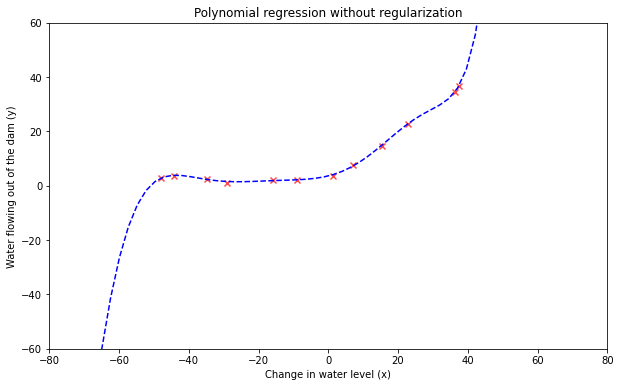

In [152]:
# Gráfico de ajustamento do modelo de regressão polinomial ao conjunto de dados

# Preparação dos valores para gerar curva de ajustamento da regressão
x = np.linspace(-65,60,50)
x = x.reshape((len(x),1))
x_polynomial = poly_features.fit_transform(x)

# Transformação usando a média e desvio padrão usando na normalização
x_polynomial = (x_polynomial - mean_norm) / std_norm
x_polynomial = np.insert(x_polynomial, 0, 1, axis=1)
new_x_polynomial = x_polynomial.dot(np.matrix(theta_poly).T)

# Gráfico de dispersão
plt.figure(figsize = (10,6))
plt.scatter(X, y, color = 'r', alpha = 0.7, marker = 'x')
plt.title('Polynomial regression without regularization')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

# Gráfico de regressão
plt.plot(x, new_x_polynomial, 'b--')
plt.axis((-80,80,-60,60))

O gráfico acima mostra um possível problema de *overfitting*. O modelo polinomial é muito complexo (complexidade desnecessária) para ajustamento dos dados (baixo viés e elevada variância). Neste caso, é possível observar que a hipótese se adapata muito bem aos dados disponíveis (modelo extremamente flexível às nuances dos dados), mas que não possui boa capacidade de generalização para prever novos dados (dados que não estavam presentes na etapa de treinamento).

**Avaliação do desempenho do modelo**

In [153]:
# Predição do modelo com valores não observados durante a etapa de treinamento do modelo
y_pred_RegPoly = modelRegLin_poly.predict(X_poly_test_norm)

Enquanto o RMSE corresponde a uma medida do desvio médio (ao quadrado) entre o valor observado ($y$) e predito ($\hat{y}$), o coeficiente de determinação ($\mathrm{R}^2$) mede o grau de ajustamento do modelo de regressão ao conjunto de dados (mede o % da variância total nos dados observados que pode ser explicado pelo modelo). Em outras palavras, o $\mathrm{R}^2$ mede quão bem a reta de regressão se ajusta ao conjunto de dados.

Uma medida similar ao RMSE é o MAE (erro médio absoluto), que mede o desvio médio (em termos absolutos) entre o valor observado ($y$) e predito ($\hat{y}$).

In [154]:
# RMSE do modelo de regressão polinomial
RegPoly_rmse = np.sqrt(mean_squared_error(y_test, y_pred_RegPoly))
print("RMSE do modelo de Regressão Polinomial: {:.2f}".format(RegPoly_rmse))

RMSE do modelo de Regressão Polinomial: 5.85


In [155]:
# MAE do modelo de regressão polinomial 
RegPoly_mae = np.sqrt(mean_absolute_error(y_test, y_pred_RegPoly))
print("MAE do modelo de Regressão Linear: {:.2f}".format(RegPoly_mae))

MAE do modelo de Regressão Linear: 1.97


In [156]:
# Coeficiente de determinação (R2) do modelo de regressão polinomial (0 <= R2 <= 1)
RegPoly_r2 = r2_score(y_test, y_pred_RegPoly)
print("Coeficiente de determinação do modelo de Regressão Linear: {:.2f}".format(RegPoly_r2))

Coeficiente de determinação do modelo de Regressão Linear: 0.83


Como esperado, as métricas de avaliação do modelo de regressão polinomial se mostraram melhores do que as do modelo de regressão linear. Visto que o grau de ajustamento do modelo de regressão linear foi inferior ao do modelo polinomial, este resultado corrbora com as curvas de ajustamento dos modelos ao conjunto de dados. 

**Curva de aprendizado**

Em virtude do fato de a classe `learning_curve` realizar por conta própria a divisão do dataset em treino e validação para comparação dos níveis de erro torna-se necessária a concateção dos subconjuntos de treino e de teste em um único dataset. Neste sentido, como o foco é a concatenação dos conjuntos de treino e de validação, não há problema de aplicar o `fit_transform` da classe `StandardScaler`. Diante disso, não há problemas se algum exemplo do grupo de validação for observado pelo conjunto de treinamento.

In [157]:
# Concatenação dos dados de treino e de validação
new_X = np.concatenate((X_poly_norm, poly_scaler.fit_transform(X_val_poly)))
new_y = np.concatenate((y, y_val))

# Novas dimensões
print("Nova dimensão da matriz de dados X: {}".format(new_X.shape))
print("Nova dimensão do vetor y: {}".format(new_y.shape))

Nova dimensão da matriz de dados X: (33, 9)
Nova dimensão do vetor y: (33,)


In [158]:
# Definição dos parâmetros para o esboço das curvas de aprendizado
train_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

sample_example, train_scores, test_scores =  learning_curve(modelRegLin_poly,
                                                            new_X, new_y,
                                                            scoring = 'neg_mean_squared_error',
                                                            train_sizes = train_sizes)

# Cálculo dos erros baseado na média dos dados de treinamento e validação
train_scores_poly_mean = np.mean(-train_scores, axis = 1)
test_scores_poly_mean = np.mean(-test_scores, axis = 1)

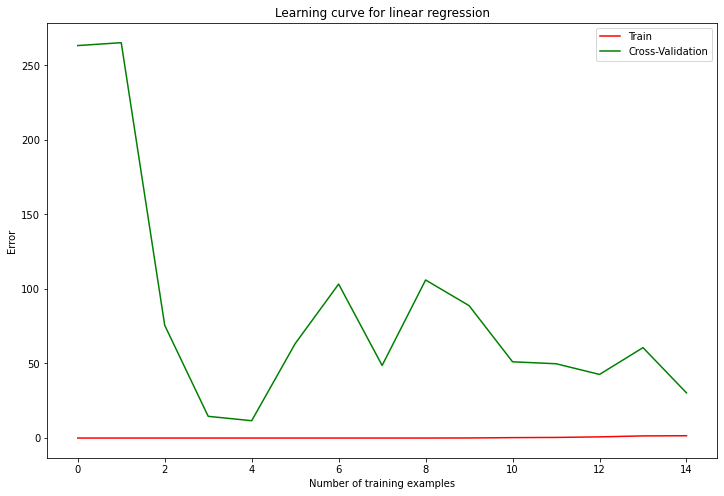

In [159]:
# Esboço das curvas de aprendizado
plt.figure(figsize = (12,8))
plt.plot(train_scores_poly_mean, color = "r")
plt.plot(test_scores_poly_mean, color="g")

plt.title("Learning curve for linear regression")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.legend(['Train', 'Cross-Validation'])

A partir do gráfico acima é possível observar que, enquanto o erro de treinamento está aparentemente nulo, o erro de validação apresenta trajetória não linear (constante) à medida que o nº de exemplos de treinamento aumenta. Apesar da trajetória não linear do erro de validação, é possível inferir que a mesma apresenta uma tendência de decrescimento. Este gráfico corrobora com a análise inferida pelo gráfico de ajustamento do modelo de regressão polinomial, onde o erro de treinamento nulo indica completa adaptação do modelo à nuances dos exemplos de treinamento e o erro de validação não constante indica a incapacidade do modelo de ajustar os hiperparâmetros aos dados de validação.

### 1.3.5. Ajuste de um regressor polinomial regularizado

**Objetivos da questão**

* Gerar 2 regressores utilizando as classes `Ridge` e `Lasso`, ambas disponíveis no pacote `sklearn.linear_model` do Scikit-Learn.

* Ajustar os valores do parâmetro alpha das regressões Ridge e lasso para controlar a quantidade de regularização que deve ser aplicada durante o aprendizado.

* Utilizar a classe `GridSearchCV` do Scikit-Learn para determinar o valor mais adequado para o hiperparâmetro `alpha` em ambos os regressores.

* Encontrar o modelo mais adequado e gerar as respectivas curvas de aprendizado.

Uma forma de encontrar um *trade-off* viés-variãncia é sintonizar a complexidade do modelo por meio da regularização. A regularização é um método útil para lidar com colinearidade (alta correlação entre as *features*), filtrar os ruídos dos dados e prevenir *overfitting*. O conceito por trá da regularização é introduzir informação adicional para penalizar os algoritmos que gerem hipóteses demasiadamente complexas, mesmo que estas hipóteses expliquem adequadamente o conjunto de treinamento (geralmente, tais hipóteses possuem baixo potencial de generalização para novos dados).

Na literatura é possível encontrar 2 tipos de regularização: regularização L2 e regularização L1.

#### (a) Regressão Ridge

**Aspectos conceituais**

Como mencionado anteriormente a regularização L2 é uma abordagem para reduzir a complexidade de um modelo pela penalização das features que possuem maiores pesos no conjunto de dados.

A regressão Ridge é um modelo não linear para regressão que utiliza como penalidade a regularização L2. No caso da regressão Ridge, os coeficientes da equação de regressão são utilizados não apenas para que prevejam bem os dados de treinamento, mas também para se adequar a uma restrição adicional (imposta pela regularização). 

Assim, visto que o modelo Ridge é mais restrito, é menos suscetível ao problema de *overfitting*.

A classe `Ridge` do Scikit-Learn implementa a regressão Ridge.

In [160]:
# Criação do objeto de regressão
modelRegLin_ridge = Ridge()

Na questão 1.2. foi observado que a otimização dos hiperparâmetros produziu modelos com melhores desempenho. Diante disso, para o desevolvimento da regressão Ridge também será realizada a otimização dos hiperparâmetros, a fim de encontrar a melhor combinação de hiperparâmetros para o modelo em questão (apesar de assumir como *default* $\alpha=1$).

O hiperparâmetro $\alpha$ permite controlar o quanto será a penalização dos coeficientes, de modo que valores de $\alpha$ mais elevados produzirão modelos mais simples. Em outras palavras, quanto maior for o valor de $\alpha$ mais simples será o modelo resultante.

A otimização/sintonização dos hiperparãmetros será realizada pela classe `GridSearchCV` do Scikit-Learn. A partir da definição dos possíveis valores para os hiperparâmetros, o `GridSearchCV` treina um modelo utilizando todos os valores e/ou combinação de valores. O modelo com o melhor desempenho é escolhido como o melhor modelo.

In [161]:
# Definição dos parâmetros candidatos para a busca da combinação dos hiperparâmetros
param_gridSearchCV = [{'alpha': [1.25, 1.5, 1.75, 2, 2.25, 2.5, 3]}]

In [162]:
# Busca pela combinação dos hiperparâmetros
modelRegLin_ridge_gridSearchCV = GridSearchCV(modelRegLin_ridge, 
                                              param_gridSearchCV,
                                              cv = 10,            # valor padrão de cv = 10
                                              scoring = 'neg_mean_squared_error',
                                              return_train_score = True)

In [163]:
# Treinamento do modelo com otimização dos hiperparâmetros
modelRegLin_ridge_gridSearchCV.fit(X_poly_norm, y)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid=[{'alpha': [1.25, 1.5, 1.75, 2, 2.25, 2.5, 3]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [164]:
# Hiperparãmetro do modelo escolhido
modelRegLin_ridge_gridSearchCV.best_params_

{'alpha': 1.25}

**Avaliação do desempenho do modelo**

In [165]:
# Predição do modelo com valores não observados durante a etapa de treinamento do modelo
modelRegLin_ridge_regressors = modelRegLin_ridge_gridSearchCV.best_estimator_          # estimador do melhor modelo escolhido
y_pred_Ridge = modelRegLin_ridge_regressors.predict(X_poly_test_norm)

Enquanto o RMSE corresponde a uma medida do desvio médio (ao quadrado) entre o valor observado ($y$) e predito ($\hat{y}$), o coeficiente de determinação ($\mathrm{R}^2$) mede o grau de ajustamento do modelo de regressão ao conjunto de dados (mede o % da variância total nos dados observados que pode ser explicado pelo modelo). Em outras palavras, o $\mathrm{R}^2$ mede quão bem a reta de regressão se ajusta ao conjunto de dados.

Uma medida similar é o MAE (erro médio absoluto), que mede o desvio médio (em termos absolutos) entre o valor observado ($y$) e predito ($\hat{y}$).

In [166]:
# RMSE do modelo de regressão Ridge
Ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_Ridge))
print("RMSE do modelo de Regressão Linear Ridge: {:.2f}".format(Ridge_rmse))

RMSE do modelo de Regressão Linear Ridge: 2.31


In [167]:
# MAE do modelo de regressão Ridge
Ridge_mae = np.sqrt(mean_absolute_error(y_test, y_pred_Ridge))
print("MAE do modelo de Regressão Linear: {:.2f}".format(Ridge_mae))

MAE do modelo de Regressão Linear: 1.35


In [168]:
# Coeficiente de determinação (R2) do modelo de regressão Ridge (0 <= R2 <= 1)
Ridge_r2 = r2_score(y_test, y_pred_Ridge)
print("Coeficiente de determinação do modelo de Regressão Ridge: {:.2f}".format(Ridge_r2))

Coeficiente de determinação do modelo de Regressão Ridge: 0.97


Em um cenário com regularização e com a otimização dos hiperparâmetros, as métricas de avaliação do modelo de regressão Ridge se apresentaram superiores às métricas dos demais modelos de regressão (linear e polinomial).

Text(0.5, 0, '$X$')

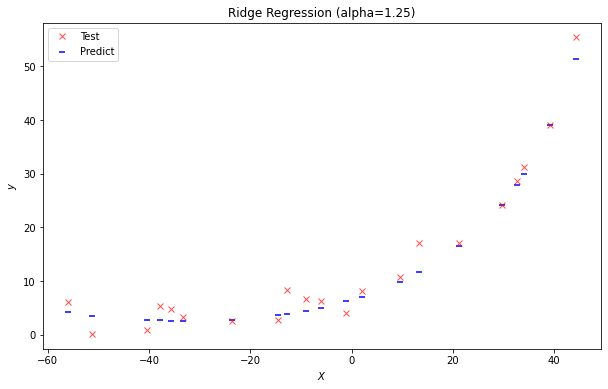

In [169]:
# Gráfico de ajustamento da modelo de regressão Ridge ao conjunto de dados
plt.figure(figsize = (10,6))
plt.plot(X_test, y_test, 'rx', alpha=0.7)
plt.scatter(X_test, y_pred_Ridge, color='b', marker='_')

plt.title('Ridge Regression (alpha=1.25)')
plt.legend(['Test', 'Predict'])
plt.ylabel('$y$', fontweight='bold')
plt.xlabel('$X$', fontweight='bold')

O gráfico de ajustamento acima mostra que o modelo de regressão Ridge consegue se ajustar ao conjunto de dados. Com relação ao modelo de regressão polinomial, o modelo de regressão Ridge se mostra menos flexível à conformação não linear do conjunto de dados.

**Curva de aprendizado**

Obs.: alguns parâmetros definidos para o esboço das curvas de aprendizado da regressão polinomial serão aproveitados para o esboço das curvas de aprendizado da regressão Ridge.

In [170]:
# Definição dos parâmetros para o esboço das curvas de aprendizado
sample_example, train_scores_ridge, test_scores_ridge =  learning_curve(modelRegLin_ridge,
                                                                        new_X, new_y,
                                                                        scoring = 'neg_mean_squared_error')

# Cálculo dos erros baseado na média dos treinamentos
train_scores_ridge = np.mean(-train_scores_ridge, axis = 1)
test_scores_ridge = np.mean(-test_scores_ridge, axis = 1)

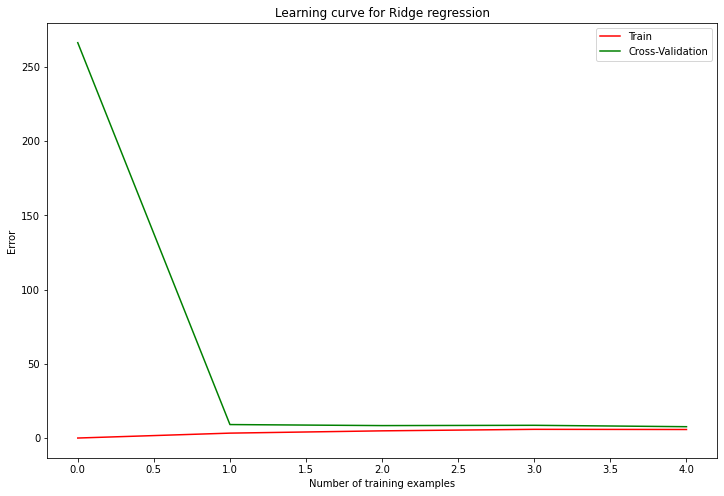

In [171]:
# Esboço das curvas de aprendizado
plt.figure(figsize = (12,8))
plt.plot(train_scores_ridge, color = "r")
plt.plot(test_scores_ridge, color="g")

plt.title("Learning curve for Ridge regression")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.legend(['Train', 'Cross-Validation'])

O gráfico acima mostra que a partir do ponto de ajustamento do algoritmo aos exemplos do conjunto de treinamento ($x = 10$), o erro de validação permanece praticamente constante e próximo de zero. Além disso, a curva do erro de treinamento é praticamente nula ao longo dos exemplos de treinamento. Este gráfico mostra que o modelo consegue se ajustar aos dados de treinamento e consegue ajustar os hiperparâmetros aos dados de validação.

#### (b) Regressão Lasso

**Aspectos conceituais**

Como mencionado anteriormente a regularização L1 é uma abordagem para reduzir a complexidade de um modelo pela penalização das features que possuem maiores pesos no conjunto de dados. Contudo, diferentemente da regularização L2, a regularização L1 geralmente produz vetores de features esparças (a maioria dos pesos das features será igual a zero). A esparsidade pode ser útil quando há um dataset com dimensão elevada, mas que possui muitos atributos irrelevantes. Neste sentido, a regularização L1 pode também ser compreendida como uma técnica para seleção de atributos. 

A regressão Lasso é uma alternativa à regressão Ridge. Contudo, diferente do primeiro, a regressão Lasso é um modelo não linear para regressão que utiliza como penalidade a regularização L1. Por fim, como no modelo Ridge, o modelo Lasso é menos suscetível ao problema de *overfitting*.

A classe `Lasso` do Scikit-Learn implementa a regressão Lasso.

In [172]:
# Criação do objeto de regressão
modelRegLin_lasso = Lasso()

Na questão 1.2. foi observado que a otimização dos hiperparâmetros produziu modelos com melhores desempenho. Diante disso, para o desevolvimento da regressão Lasso também será realizada a otimização dos hiperparâmetros, a fim de encontrar a melhor combinação de hiperparâmetros para o modelo em questão (apesar de assumir como *default* $\alpha=1$).

O hiperparâmetro $\alpha$ permite controlar o quanto será a penalização dos coeficientes, de modo que valores de $\alpha$ mais elevados produzirão modelos mais simples. Em outras palavras, quanto maior for o valor de $\alpha$ mais simples será o modelo resultante.

A otimização/sintonização dos hiperparãmetros será realizada pela classe `GridSearchCV` do Scikit-Learn. A partir da definição dos possíveis valores para os hiperparâmetros, o `GridSearchCV` treina um modelo utilizando todos os valores e/ou combinação de valores. O modelo com o melhor desempenho é escolhido como o melhor modelo.

Obs.: para a aplicação do algoritmo de *grid search* para a regressão Lasso será utilizada a mesma definição dos parâmetros candidatos utilizada na regressão Ridge.

In [173]:
# Busca pela combinação dos hiperparâmetros
modelRegLin_lasso_gridSearchCV = GridSearchCV(modelRegLin_lasso, 
                                              param_gridSearchCV,
                                              cv = 10,            # valor padrão de cv = 10
                                              scoring = 'neg_mean_squared_error',
                                              return_train_score = True)

In [174]:
# Treinamento do modelo com otimização dos hiperparâmetros
modelRegLin_lasso_gridSearchCV.fit(X_poly_norm, y)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid=[{'alpha': [1.25, 1.5, 1.75, 2, 2.25, 2.5, 3]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [175]:
# Hiperparãmetro do modelo escolhido
modelRegLin_lasso_gridSearchCV.best_params_

{'alpha': 1.25}

**Avaliação do desempenho do modelo**

In [176]:
# Predição do modelo com valores não observados durante a etapa de treinamento do modelo
modelRegLin_lasso_regressors = modelRegLin_lasso_gridSearchCV.best_estimator_         # estimador do melhor modelo escolhido
y_pred_Lasso = modelRegLin_lasso_regressors.predict(X_poly_test_norm)

Enquanto o RMSE corresponde a uma medida do desvio médio (ao quadrado) entre o valor observado ($y$) e predito ($\hat{y}$), o coeficiente de determinação ($\mathrm{R}^2$) mede o grau de ajustamento do modelo de regressão ao conjunto de dados (mede o % da variância total nos dados observados que pode ser explicado pelo modelo). Em outras palavras, o $\mathrm{R}^2$ mede quão bem a reta de regressão se ajusta ao conjunto de dados.

Uma medida similar ao RMSE é o MAE (erro médio absoluto), que mede o desvio médio (em termos absolutos) entre o valor observado ($y$) e predito ($\hat{y}$).

In [177]:
# RMSE do modelo de regressão Lasso
Lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_Lasso))
print("RMSE do modelo de Regressão Linear Lasso: {:.2f}".format(Lasso_rmse))

RMSE do modelo de Regressão Linear Lasso: 4.58


In [178]:
# MAE do modelo de regressão Lasso
Lasso_mae = np.sqrt(mean_absolute_error(y_test, y_pred_Lasso))
print("MAE do modelo de Regressão Linear Lasso: {:.2f}".format(Lasso_mae))

MAE do modelo de Regressão Linear Lasso: 1.69


In [179]:
# Coeficiente de determinação (R2) do modelo de regressão Lasso (0 <= R2 <= 1)
Lasso_r2 = r2_score(y_test, y_pred_Lasso)
print("Coeficiente de determinação do modelo de Regressão Lasso: {:.2f}".format(Lasso_r2))

Coeficiente de determinação do modelo de Regressão Lasso: 0.90


Em um cenário com regularização e com a otimização dos hiperparâmetros, as métricas de avaliação do modelo de regressão Lasso se apresentaram superiores às métricas dos demais modelos de regressão (linear e polinomial), mas inferior às métricas do modelo de regressão Ridge.

Text(0.5, 0, '$X$')

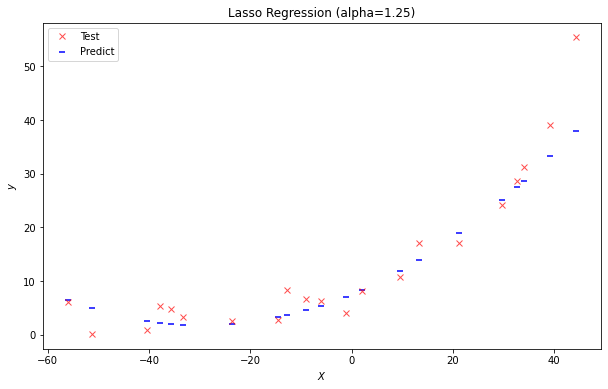

In [181]:
# Gráfico de ajustamento do modelo de regressão Lasso ao conjunto de dados
plt.figure(figsize = (10,6))
plt.plot(X_test, y_test, 'rx', alpha=0.7)
plt.scatter(X_test, y_pred_Lasso, color='b', marker='_')

plt.title('Lasso Regression (alpha=1.25)')
plt.legend(['Test', 'Predict'])
plt.ylabel('$y$', fontweight='bold')
plt.xlabel('$X$', fontweight='bold')

O gráfico de ajustamento acima mostra que o modelo de regressão Lasso consegue se ajustar ao conjunto de dados. Com relação ao modelo de regressão polinomial, o modelo de regressão Lasso se mostra menos flexível à conformação não linear do conjunto de dados (semelhante ao gráfico de ajustamento do modelo de regressão Ridge).

**Curva de aprendizado**

Obs.: alguns parâmetros definidos para o esboço das curvas de aprendizado da regressão polinomial serão aproveitados para o esboço das curvas de aprendizado da regressão Lasso.

In [182]:
# Definição dos parâmetros para o esboço das curvas de aprendizado
sample_example, train_scores_lasso, test_scores_lasso =  learning_curve(modelRegLin_lasso,
                                                                        new_X, new_y,
                                                                        scoring = 'neg_mean_squared_error')

# Cálculo dos erros baseado na média dos treinamentos
train_scores_lasso = np.mean(-train_scores_lasso, axis = 1)
test_scores_lasso = np.mean(-test_scores_lasso, axis = 1)

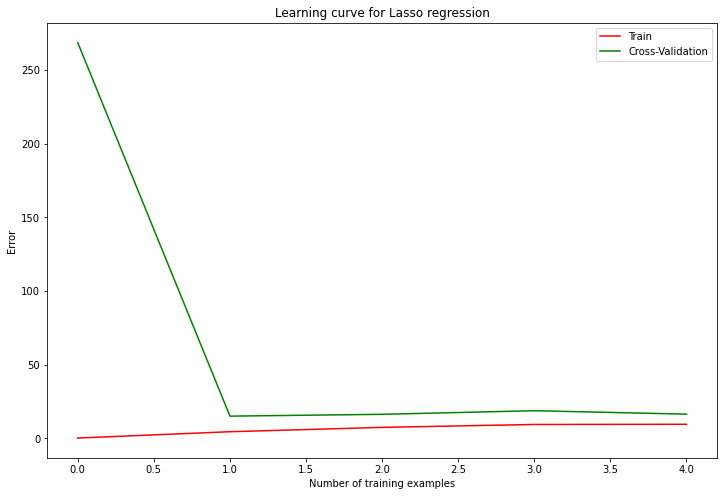

In [183]:
# Esboço das curvas de aprendizado
plt.figure(figsize = (12,8))
plt.plot(train_scores_lasso, color = "r")
plt.plot(test_scores_lasso, color="g")

plt.title("Learning curve for Lasso regression")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.legend(['Train', 'Cross-Validation'])

O gráfico acima mostra que a partir do ponto de ajustamento do algoritmo aos exemplos do conjunto de treinamento ($x = 10$), o erro de validação permanece praticamente constante e próximo de zero. Além disso, a curva do erro de treinamento é praticamente nula ao longo dos exemplos de treinamento. Este gráfico mostra que o modelo consegue se ajustar aos dados de treinamento e consegue ajustar os hiperparâmetros aos dados de validação.

**Discussão**

A discussão dos resultados obtidos na questão 1.3. são divididos em 3 grupos:

* Análise das métricas de avaliação dos modelos de regressão.

* Análise dos gráficos de ajustamento do modelo de regressão ao conjunto de dados.

* Análise das curvas de aprendizado.

(a) Análise das métricas de avaliação dos modelos de regressão:

| Modelo | RMSE | MAE | $\mathrm{R}^2$ |
| :----: | :----: | :----: | :----: |
| Regressão Linear | 8.06 | 2.41 | 0.68 |
| Regressão Polinomial | 5.85 | 1.97 | 0.83 |
| Regressão Ridge | 2.31 | 1.35 | 0.97 |
| Regressão Lasso | 4.58 | 1.69 | 0.90 |

Como esperado, o modelo de Regressão Polinomial obteve métricas melhores em comparação ao modelo de Regressão Linear, visto que o primeiro sofre de *underfitting* e o segundo sofre de *overfitting*. No global, os modelos de Regressão Lasso e Ridge (com otimização dos hiperparâmetros) apresentaram desempenho superior, visto que a regularização tenta mitigar os problemas de *overfitting*.

(b) Análise dos gráficos de ajustamento do modelo de regressão ao conjunto de dados:

Pelos gráficos de ajustamento do modelo de regressão ao conjunto de dados é possível observar que os modelos de regressão linear e polinomial representam casos extremos de pouco ajustamento e de excesso de ajustamento do modelo aos dados. Além disso, apesar dos gráficos de regressão com regularização (Ridge e Lasso) mostrarem que os modelos se ajustam bem aos dados, mostram também que os modelos são menos flexíveis do que o modelo de regressão polinomial.

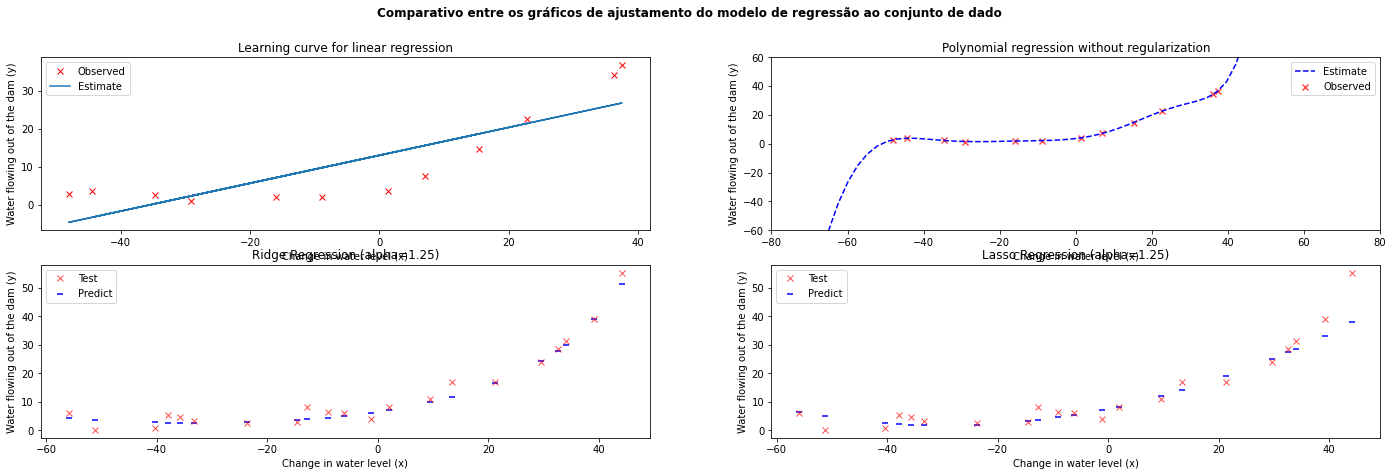

In [186]:
fig = plt.figure(figsize=(24,7))
fig.suptitle('Comparativo entre os gráficos de ajustamento do modelo de regressão ao conjunto de dado', fontweight='bold')

# Criação dos subplots
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Regressão Linear
ax1.plot(X, y, 'rx')
ax1.plot(X, (theta0 + theta1*X))
ax1.set_title('Linear Regression')
ax1.set_title("Learning curve for linear regression")
ax1.set_xlabel("Change in water level (x)")
ax1.set_ylabel("Water flowing out of the dam (y)")
ax1.legend(['Observed', 'Estimate'])

# Regressão Logística
ax2.scatter(X, y, color = 'r', alpha = 0.7, marker = 'x')
ax2.set_title('Polynomial regression without regularization')
ax2.plot(x, new_x_polynomial, 'b--')
ax2.axis((-80,80,-60,60))
ax2.set_xlabel("Change in water level (x)")
ax2.set_ylabel("Water flowing out of the dam (y)")
ax2.legend(['Estimate', 'Observed'])

# Regressão Ridge
ax3.plot(X_test, y_test, 'rx', alpha=0.7)
ax3.scatter(X_test, y_pred_Ridge, color='b', marker='_')
ax3.set_title('Ridge Regression (alpha=1.25)')
ax3.set_xlabel("Change in water level (x)")
ax3.set_ylabel("Water flowing out of the dam (y)")
ax3.legend(['Test', 'Predict'])

# Regressão Lasso
ax4.plot(X_test, y_test, 'rx', alpha=0.7)
ax4.scatter(X_test, y_pred_Lasso, color='b', marker='_')
ax4.set_title('Lasso Regression (alpha=1.25)')
ax4.set_xlabel("Change in water level (x)")
ax4.set_ylabel("Water flowing out of the dam (y)")
ax4.legend(['Test', 'Predict'])

(c) Análise das curvas de aprendizado:

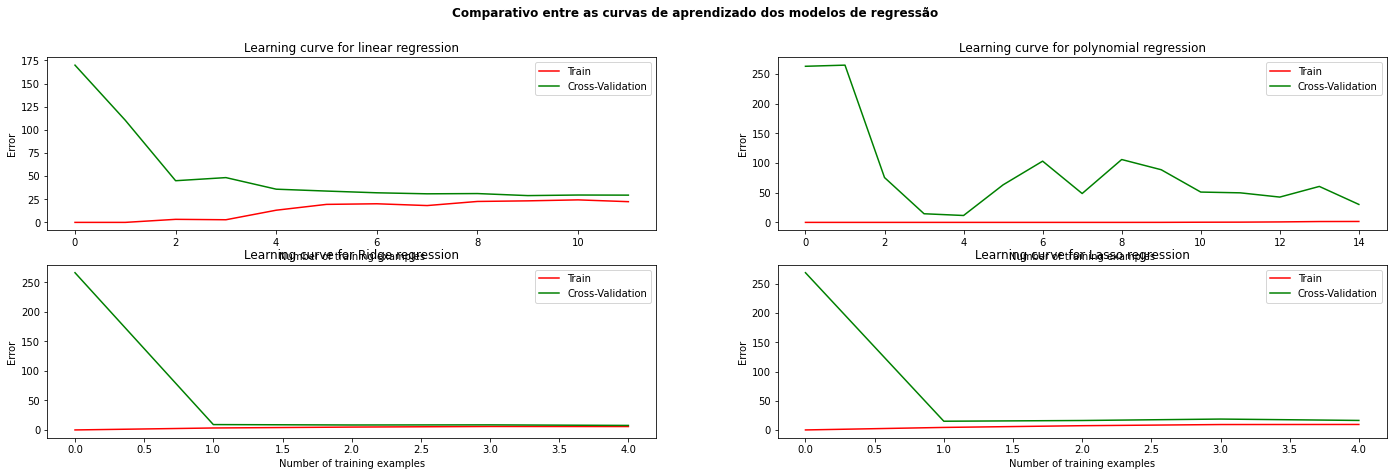

In [185]:
fig = plt.figure(figsize=(24,7))
fig.suptitle('Comparativo entre as curvas de aprendizado dos modelos de regressão', fontweight='bold')

# Criação dos subplots
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Regressão Linear
ax1.plot(train_scores_reg, color = "r")
ax1.plot(val_scores_reg, color="g")
ax1.set_title("Learning curve for linear regression")
ax1.set_xlabel("Number of training examples")
ax1.set_ylabel("Error")
ax1.legend(['Train', 'Cross-Validation'])

# Regressão Logística
ax2.plot(train_scores_poly_mean, color = "r")
ax2.plot(test_scores_poly_mean, color="g")
ax2.set_title("Learning curve for polynomial regression")
ax2.set_xlabel("Number of training examples")
ax2.set_ylabel("Error")
ax2.legend(['Train', 'Cross-Validation'])

# Regressão Ridge
ax3.plot(train_scores_ridge, color = "r")
ax3.plot(test_scores_ridge, color="g")
ax3.set_title("Learning curve for Ridge regression")
ax3.set_xlabel("Number of training examples")
ax3.set_ylabel("Error")
ax3.legend(['Train', 'Cross-Validation'])

# Regressão Lasso
ax4.plot(train_scores_lasso, color = "r")
ax4.plot(test_scores_lasso, color="g")
ax4.set_title("Learning curve for Lasso regression")
ax4.set_xlabel("Number of training examples")
ax4.set_ylabel("Error")
ax4.legend(['Train', 'Cross-Validation'])

Pelos gráficos acima é possível observar os seguintes pontos:

* Com exceção do modelo de regressão linear, a curva de erro de treinamento é nula em todos os casos analisados.

* Enquanto que o ponto de ajuste do algoritmo aos exemplos do conjunto de treinamento ocorre entre 2 e 4 para os modelos de regressão linear e de regressão polinomial, para os modelos de regressão com regularização (Ridge e Lasso) esse ponto ocorre depois (aproximadamente no ponto 10). Isso mostra que os modelos com regularização precisam de mais exemplos do conjunto de treinamento para que o algoritmo começe a se ajustar.

* Os gráficos dos modelos de regressão com regularização (Ridge e Lasso) mostram que, uma vez alcançado o ponto de ajustamento do algoritmo ao conjunto de dados, o erro de validação permanece constante e próximo de zero. Comportanemto distinto pode ser observado com relação aos modelos de regressão linear e polinomial, cujo erro de validação não é linear ao longo dos exemplos do conjunto de treinameto.

* No caso dos modelos de regressão com regularizaçãoi (Ridge e lasso), o modelo consegue se ajustar aos dados de treinamento e consegue ajustar os hiperparâmetros aos dados de validação.

* No modelo de regressão polinomial, o erro de treinamento nulo indica completa adaptação do modelo à nuances dos exemplos de treinamento e o erro de validação não constante indica a incapacidade do modelo de ajustar os hiperparâmetros aos dados de validação.

# 2. Redução de Dimensionalidade

**Bibliotecas necessárias para a questão 2**

In [187]:
# Leitura de arquivos ".mat"
import scipy.io          
import scipy.io as spio

# Manipulação de dados tabulares
import numpy as np

# Visualização gráfica
import matplotlib.pyplot as plt

**Objetivo da questão**

* Realizar experimentos com um conjunto de dados em 2D para obter intuição sobre como o PCA funciona.

## 2.1. Conjunto de dados de exemplo

**Objetivos da questão**

* Aplicar o PCA aum conjunto de dados 2D (que tem uma direção de grande variação e uma direção de menor variação).

* Plotar o gráfico com os dados de treinamento e visualizar o que acontece quando o PCA é utilizado para reduzir os dados de 2D para 1D.

**Aspectos conceituais**

O propósito da redução de dimensionalidade é diminuir o elevado número de atributos de um conjunto de dados, de modo que a nova matriz contenha somente os atributos que são importantes para a tarefa de *machine learning*. Uma dos métodos de redução de dimensionalidade é a Análise de Componentes Principais (PCA), que utiliza o processo de transformação linear ortogonal para transformar um conjunto de dados com elevada dimensão de features (possivelmente correlacionadas) em um conjunto com uma dimensionalidade menor de atributos linearmente não correlacionados.

Em uma transformação de PCA, o número de componentes principais é sempre menor ou igual ao número de atributos. Além disso, cada componente principal tenta capturar a maior parte da variância, de modo que sejam ortogonais aos componentes anteriores. Diante disso, o principal objetivo é tomar um conjunto inicial de dados ($\mathbf{X}$) e reduzi-lo a um subconjunto de componentes principais extraídos de uma dimensão menor.

Em resumo, as principais etapas do PCA são:

* Normalização dos exemplos do conjunto de dados $\mathbf{X}$.

* Cálculo da matriz de covariância $\mathbf{\Sigma}$.

* Cálculo da decomposição por valores singulares (SVD) da matriz de covariância $\mathbf{\Sigma}$.

* Projeção dos dados normalizados.

**Leitura dos dados**

In [188]:
# Leitura do arquivo
filepath = 'Data/ex7data1.mat'
data = spio.loadmat(filepath, squeeze_me = True)
X = data['X']

**Visualização dos dados**

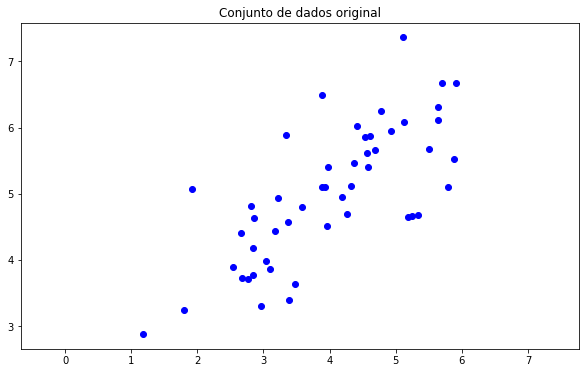

In [190]:
#  Visualize the example dataset
plt.figure(figsize = (10,6))
plt.plot(X[:, 0], X[:, 1], 'bo')
plt.axis([0.5, 6.5, 2, 8])
plt.axis('equal')
plt.title('Conjunto de dados original')
plt.show()

## 2.2. Implementando o PCA

**Objetivos da questão**

* Normalizar os dados.

* Complementar a implementação do PCA.

* Implementar a função que foi completada.

* Compreender a aplicação do PCA sobre o conjunto de dados de exemplo e a apresentação dos dados projetados em 1D.

### 2.2.1. Normalização dos dados

**Aspectos conceituais**

Visto que o PCA é um método de redução de dimensionalidade sensível às escalas, o primeiro passo é a normalização dos atributos a fim de lidar com as discrepâncias entre as escalas de medida existentes no conjunto de dados.

A função `featureNormalize` normaliza os atributos contidos no conjunto de dados $\mathbf{X}$ e retorna uma versão normalizada deste dataset, onde cada atributo passa a ter média e desvio padrão iguais a zero e a 1, respectivamente. Resumidamente, os atributos serão normalizados conforme a seguinte expressão:

$$
x^{(i)}_{norm} = \frac{x^{(i)} - \mu_i}{\sigma^2_i}
$$

onde $x^{(i)}_{norm}$ é o atributo $x^{(i)}$ normalizado, $\mu_i$ e $\sigma^2_i$ são a média e o desvio padrão do atributo $x^{(i)}$, respectivamente.

In [191]:
# Normalização dos atributos da matriz de dados X
def featureNormalize(X):
    # Cálculo da média
    mu = X.mean(axis=0)  
    
    # Cálculo do desvio padrão
    sigma = X.std(axis=0)
    
    # Normalização da feature
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

In [192]:
#  Normalização do conjunto de dados X (antes da execução do PCA)
X_norm, mu, sigma = featureNormalize(X)

### 2.2.2. Implementação do PCA

**Aspectos conceituais**

O PCA trabalha pela decomposição da matriz de covariância dos dados utilizando a Decomposição por Valores Singulares (SVD). Esta decomposição existe para todas as matrizes e retorna a seguinte fatoração da matriz de dados $\mathbf{X}$.

$$
\mathbf{X} = \mathbf{U} \times \mathbf{S} \times \mathbf{V}^T \ \Rightarrow \ [\mathbf{U}, \mathbf{S}, \mathbf{V}]: = \text{svd}(\mathbf{\Sigma})
$$

Em virtude da matriz de covariância $\mathbf{\Sigma}$ ser simétrica, $\mathbf{U} = \mathbf{V}$. Os elementos da matriz diagonal $\mathbf{S}$ são valores singulares de $\mathbf{X}$, cujos quadrados são os autovalores de $\mathbf{X^T}\mathbf{X}$. A matriz de autovetores $\mathbf{U}$ é ortogonal (cada coluna de $\mathbf{U}$ é um autovetor), ou seja, $\mathbf{X^T}\mathbf{X}=\mathbf{I}$. Os valores estão em ordem decrescente de modo que a primeira coluna de $\mathbf{U}$ é o eixo correspondente ao maior valor singular (esta é a primeira coluna dominante que identifica o PCA). Diante disso, é possível mostrar que todos os componentes principais estão contidos em $\mathbf{U}$, considerando uma matriz de dados $\mathbf{X}$:

$$
\mathbf{U}_{(n \times n)}= 
\begin{bmatrix}
PC_1\\
PC_2\\
\dots \\
PC_n\\
\end{bmatrix}
$$

Obs.: Os autovetores são os eixos (direções) ao longo do qual uma transformações linear age (por meio da compressão e da rotaçaõ) e os autovalores fornecem os fatores pelos quais a compressão ocorre. Em outras palavras, um autovetor de uma transformação linear é um vetor não nulo cuja direção não muda quando uma transformação linear é aplicada.

Obs.: Matriz de covariância de $\mathbf{X}$: 

$$
\mathbf{\Sigma}=\frac{1}{m-1}(\mathbf{X^T}\mathbf{X})
$$

onde $m$ é o número de exemplos. Um ponto que vale a pena discutir é a utilização de $m-1$ (em vez de $m$). Como geralmente os dados utilizados são amostrais, a utilização do termo $m-1$ é justificada. Caso, fossem utilizados dados populacionais, então o denominador seria composto somente por $m$.

A partir das entradas da matriz $\mathbf{\Sigma}$, o SVD encontra as transformações ortogonais que são ideais para alinhar os componentes ao longo das direções que estão mais fortemente associadas com essas relações correlacionadas.

Uma vez normalizados os dados, é possível calcular os componentes principais. A função `pca` calcula a matriz de covariância do conjunto de dados $\mathbf{X}$ e, em seguida, o SVD para computar os componentes principais (conhecidos também como autovetores da matriz de covariância de $\mathbf{X}$).

In [193]:
# Cálculo do PCA
def pca(X):
    # Valores úteis
    m, n = X.shape
    U = np.zeros(n)
    S = np.zeros(n)

    # Cálculo da matriz de covariância do conjunto de dados X (matriz Sigma)
    sigma = (1 / m) * np.matmul(X.transpose(), X)
    
    # Decomposição da matriz de covariância de X 
    u, s, _ = np.linalg.svd(sigma)
    U = u                              # Vetor de componentes principais
    S = np.diag(s)                     # Matriz diagonal
    return U, S

In [194]:
#  Execução do PCA
U, S = pca(X_norm)

In [195]:
# Vetores componentes da base (na qual a matriz de dados original foi projetada)
print("Primeiro Componente principal (1º autovetor): {}".format(U[:, 0]))
print("Segundo Componente principal (2º autovetor): {}".format(U[:, 1]))

Primeiro Componente principal (1º autovetor): [-0.70710678 -0.70710678]
Segundo Componente principal (2º autovetor): [-0.70710678  0.70710678]


**Visualização dos dados**

Para ter uma intuição de como o PCA está trabalhando é possível esboçar um gráfico com os autovetores centrados na média dos dados. As linhas mostram as direções de máxima variância no dataset.

A função `drawLine` esboça as linhas correspondentes aos componentes principais.

In [196]:
# Esboço das linhas correspondentes aos componentes principais
def drawLine(p1, p2, *args, **kwargs):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], *args, **kwargs)

Top autovetor (1º Componente Principal): [-0.70710678 -0.70710678]


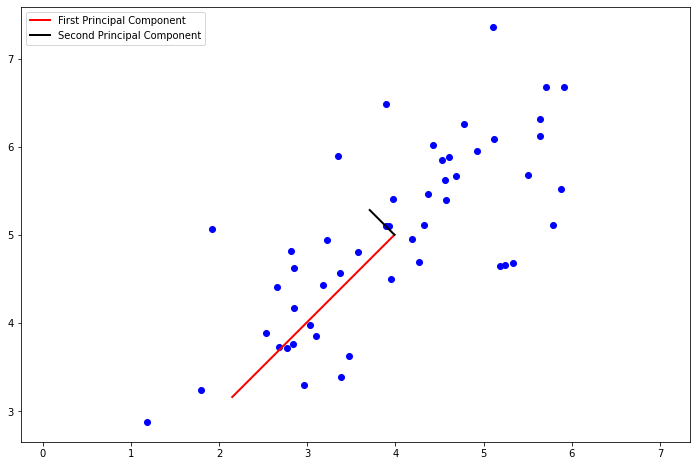

In [199]:
print('Top autovetor (1º Componente Principal): {}'.format(U[:, 0]))

#  Gráfico dos autovetores centrados na média.
# As linhas mostram as direções dos principais componentes (ou seja, as direções das máximas variâncias).
plt.figure(figsize=(12,8))
plt.plot(X[:, 0], X[:, 1], 'bo')
plt.axis([0.5, 6.5, 2, 8])
plt.axis('equal')
drawLine(mu, mu + 1.5 * S[0, 0] * U[:, 0], '-k', linewidth=2, color='red', label = 'First Principal Component')
drawLine(mu, mu + 1.5 * S[1, 1] * U[:, 1], '-k', linewidth=2, label = 'Second Principal Component')

plt.legend(loc=2)
plt.show()

Pelo gráfico acima é possível observar os seguintes pontos:

* A direção correspondente ao 1º componente principal contem a maior parte da informação.

* Os componentes principais são vetores ortogonais. 

## 2.3. Redução de Dimensionalidade com PCA

**Objetivo da questão**

* Utilizar os autovetores retornados pelo PCA para projetar o conjunto de dados em um espaço unidimensional.

### 2.3.1 Projetando os dados nos componentes principais

**Objetivos da questão**

* Analisar o funcionamento da função `project.data`.

* Projetar o primeiro exemplo de $X$ na primeira dimensão.

**Aspectos conceituais**

O PCA é capaz de reduzir a dimensionalidade do conjunto de dados $\mathbf{X}$ por meio da projeção linear. Assim, depois de calcular os componentes principais, é possível utilizá-lo para reduzir a dimensão dos atributos do conjunto de dados $\mathbf{X}$ por meio da projeção de cada exemplo em um espaço com menor dimensionalidade (de $\mathbf{X}$ para $\mathbf{Z}$).

A função `projectData`calcula a projeção dos dados normalizados de $\mathbf{X}$ em um espaço dimensional reduzido, medido pelos primeiras $k$ colunas de $\mathbf{U}$ (representação reduzida decorrente da projeção dos top $k$ autovetores).

In [200]:
# Cálculo da projeção dos dados normalizados da matriz de dados X
def projectData(X, U, K):
    Z = np.matmul(X, U[:, :K])  # Produto de 2 arrays (U reduzido e X normalizado)
    return Z

In [201]:
#  Projeção dos dados em um espaço de 1 diomensão
K = 1                         
Z = projectData(X_norm, U, K)
print('Projeção do primeiro exemplo: {:.3f}'.format(Z[0, 0]))

Projeção do primeiro exemplo: 1.496


In [203]:
# Comparativo entre dados originais, dados normalizados e a projeção do 1º exemplo
print('Dado original: {}'.format(X[0]))
print('Dado normalizado: {}'.format(X_norm[0]))
print('Projeção do primeiro exemplo: {:.8f}'.format(Z[0, 0]))

Dado original: [3.38156267 3.38911268]
Dado normalizado: [-0.52331306 -1.59279252]
Projeção do primeiro exemplo: 1.49631261


### 2.3.2. Reconstruindo uma aproximação dos dados

**Objetivo da questão**

* Analisar o código da função `recover_data` que projeta cada exemplo em $Z$ de volta ao espaço original e retorna a aproximação recuperada em `X_rec`.

* Utilizar a função `recover_data` para recuperar uma aproximação do primeiro exemplo em $X$.

**Aspectos conceituais**

Depois de projetar os dados para um espaço dimensional menor, é possível recuperar aproximadamente os dados projetando-os de volta no espaço original (com dimensão superior).

A função `recoverData` realiza a recuperação aproximada dos dados originais usando os dados projetados (recupera uma aproximação dos dados originais que foram reduzidos para $k$ dimensão).

In [204]:
# Recuperação aproximada dos dados originais via dados projetados
def recoverData(Z, U, K):
    X_rec = np.matmul(Z, U.transpose()[:K])
    return X_rec

In [205]:
X_rec  = recoverData(Z, U, K)
print('Aproximação do primeiro exemplo: {}'.format(X_rec[0]))

Aproximação do primeiro exemplo: [-1.05805279 -1.05805279]


Depois de calcular a projeção e realizar a recuperação aproximada dos dados é importante plotar um gráfico para visualizar como a projeção afeta os dados.

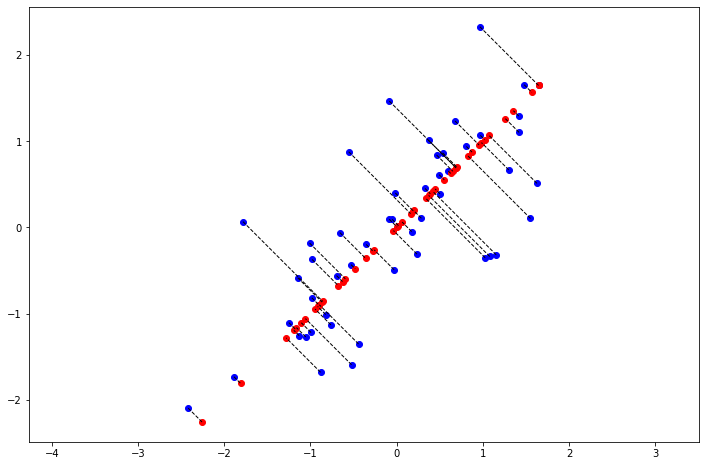

In [207]:
#  Gráfico dos dados normalizados
plt.figure(figsize=(12,8))
plt.plot(X_norm[:, 0], X_norm[:, 1], 'bo')
plt.axis([-4, 3, -4, 3])
plt.axis('equal')

#  Linha conectando os dados projetados aos dados originais 
plt.plot(X_rec[:, 0], X_rec[:, 1], 'ro')
for i in range(X_norm.shape[0]):
    drawLine(X_norm[i], X_rec[i], '--k', linewidth=1)
plt.show()

# 3. Agrupamento

**Bibliotecas necessárias para a questão 3**

In [208]:
# Manipulação de dados tabulares
import numpy as np

# Visualização gráfica
import matplotlib.pyplot as plt

# Leitura de arquivos ".mat"
import scipy.io

## 3.1. Implementando k-Means

**Objetivo da questão**

* Implementar o algoritmo K-means sobre um conjunto de dados 2D.

**Aspectos conceituais**

Clusterização é a tarefa de identificar instâncias similares e atribuí-las aos clusters (grupos de instâncias similares). Estes grupos podem ser formados com base em padrões similares ou atributos comuns presentes nos dados. Como na tarefa de classificação, na clusterização cada instância é atrinuída a um grupo. Por outro lado, enquanto a classificação é uma tarefa supervisionada, a clusterização é uma tarefa não supervisionada.

k-Means é um algoritmo de clusterização capaz de agrupar os exemplos de um conjunto de dados com poucas iterações. Portanto, este algoritmo procura por um número predeterminado de clusters dentro de um dataset multidimensional não rotulado. Para este fim, o algoritmo utiliza as seguintes hipóteses acerca da concepção de clusterização ótima:

* O centro do cluster (centróide) é a média aritmética de todos os pontos pertencentes a um cluster.

* Cada ponto está mais próximo do seu centróide do que dos demais centróides.

**Leitura dos dados**

In [209]:
raw_mat = scipy.io.loadmat("Data/ex7data2.mat")
X = raw_mat.get("X")

**Visualização dos dados**

Para enfatizar que este é um algoritmo não supervisionado o seguinte gráfico será plotado. A partir da visualização gráfica é possível observar que os pontos aparentemente estão agrupados em clusters (apesar de ainda não ser possível distinguir os grupos).

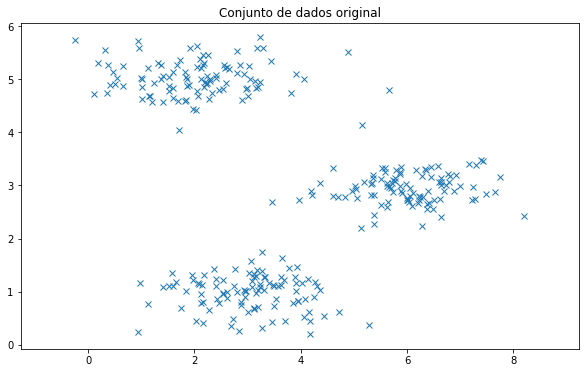

In [210]:
plt.figure(figsize=(10,6))
plt.plot(X[:, 0], X[:, 1], 'x')
plt.axis([0.5, 6.5, 2, 8])
plt.axis('equal')
plt.title('Conjunto de dados original')
plt.show()

Pelo gráfico acima é possível observar a formação de 3 grupos de dados, contudo ainda não informações suficientes para delimitar com precisão cada grupo existente neste dataset.

In [211]:
# Análise da dimensão do dataset
(m,n) = X.shape
print('Dimensão do conjunto de dados: (%d,%d)'%(m,n))

Dimensão do conjunto de dados: (300,2)


O dataset é composto por 300 pontos que estão aparentemente agrupados em 3 regiões, conforme observado pelo gráfico acima.

**Aspectos conceituais**

O algoritmo k-Means é um processo iterativo de movimentar os centróides para a posição média de seus pontos constituintes e reatribuindo as instâncias para seus clusters mais próximos de forma iterativa até que não haja mudança significativa no número de centróides ou o número de iterações definidas tenha sido alcançada. Diante disso, o objetivo deste tópico é implementar o algoritmo de k-Means, que é composto pelas seguintes etapas:

* Localização dos centróides mais próximos.

* Cálculo dos centróides.

* Movimentação dos centróides para o centro dos respectivos grupos.

Conforme mencionado, o ponto de parada deste processo iterativo será quando os clusters atribuídos não sofrerem mais alterações ou quando um número máximo de iterações definido pelo usuário tiver sido alcançado.

Nas seções seguintes será possível observar a construção das etapas necessárias para a execução do algoritmo k-Means.

## 3.2. Encontrando os centróides mais próximos

**Objetivos da questão**

* Completar o código da função `find_closest_centroids`.

* Executar o script para produzir a saída dos 3 primeiros exemplos.

**Aspectos conceituais**

Conforme mencionado na seção anterior, a primeira etapa do algoritmo de k-Means é a localização dos centróides mais próximos. Ratificando o entendimento, como ponto de partida os centróides são criados em locais aleatórios. A partir daí, para cada observação do conjunto de dados são realizadas as seguintes etapas:

* Cálculo da distância entre estes pontos e os centróides criados.

* Atribuição de cada observação ao cluster cujo centróide esteja mais próximo.

A função `find_closest_centroids`calcula os centróides mais próximos dentro do conjunto de dados. Esta função possui dois inputs, o conjunto de dados X e o hiperparâmetro K, que representa o número de clusters necessários (que corresponde ao número de centróides). 

In [212]:
# Cálculo dos centróides mais próximos
def find_closest_centroids(X, centroids):
    # Inicialização
    K = centroids.shape[0]
    m = X.shape[0]
    
    distance = np.zeros((m, K))
    for i in range(K):
        distance[:, i] = np.diag(np.matmul(X - centroids[i], (X - centroids[i]).transpose()))
        
    idx = distance.argmin(axis=1)
    
    return idx

In [213]:
# Conjunto inicial de centroides
K = 3                                                     # nº de centroides
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])    # Valores arbitrários para os centróides iniciais
idx = find_closest_centroids(X, initial_centroids)
print('Centroides mais próximos para os 3 primeiros exemplos: {}'.format(idx[:3]))

Centroides mais próximos para os 3 primeiros exemplos: [0 2 1]


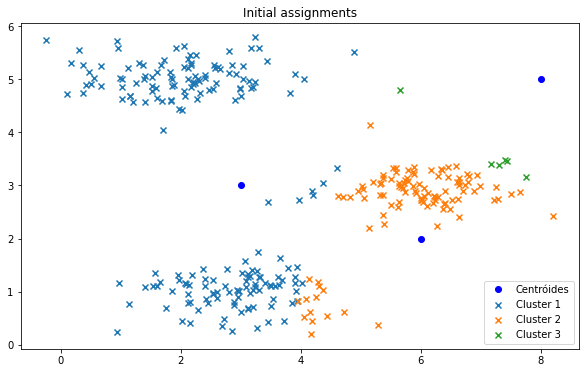

In [215]:
# Localização gráfica dos centróides mais próximos
plt.figure(figsize=(10,6))

# Gráfico das atribuições iniciais das observaões aos clusters
plt.scatter(X[np.where(idx == 0),0],X[np.where(idx == 0),1], marker = 'x', label = 'Cluster 1')
plt.scatter(X[np.where(idx == 1),0],X[np.where(idx == 1),1], marker = 'x', label = 'Cluster 2')
plt.scatter(X[np.where(idx == 2),0],X[np.where(idx == 2),1], marker = 'x', label = 'Cluster 3')

# Centróide de cada grupo
plt.plot(initial_centroids[:,0], initial_centroids[:,1], 'bo', label = 'Centróides')

plt.legend(loc = 4)
plt.title('Initial assignments')
plt.show()

## 3.3. Atualização dos centróides

**Objetivos da função**

* Completar o código da função `compute_centroids`.

* Executar o script para gerar os centróides resultantes após 10 iterações do K-means.

Após o cálculo dos centróides e a atribuição das observações aos grupos cujos centróides estão mais próximos, a próxima etapa é o recálculo dos novos centróides, para cada cluster. Para este fim, para cada centróide, é recalculada a média dos pontos que foram atribuídos a ele.

A função `compute_centroids` recalcula os novos centróides tomando os valores médios de todos os pontos contidos no cluster (em outras palavras, de todos os pontos atribuídos a cada centróide).

In [216]:
# Atualização do cálculo dos centróides
def compute_centroids(X, idx, K):
    # Variáveis úteis
    m, n = X.shape
    
    centroids = np.zeros((K, n))
    
    for i in range(K):
        centroids[i] = X[idx == i].mean(axis=0)
        
    return centroids

In [217]:
# Cálculo dos valores médios com base nos centróides encontrados anteriormente
updated_centroids = compute_centroids(X, idx, K)
print('Centróides atualizados: \n{}'.format(updated_centroids.T))

Centróides atualizados: 
[[2.42830111 5.81350331 7.11938687]
 [3.15792418 2.63365645 3.6166844 ]]


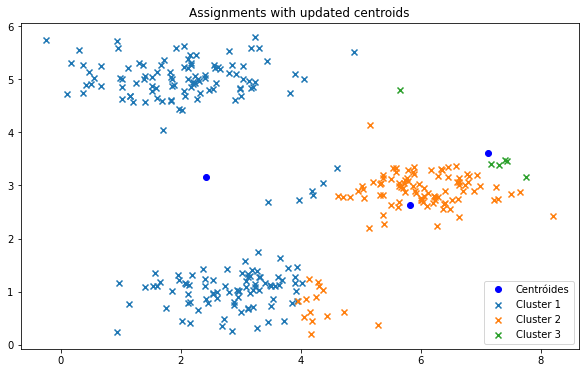

In [218]:
# Localização gráfica dos centróides atualizados
plt.figure(figsize=(10,6))

# Gráfico das atribuições iniciais das observaões aos clusters
plt.scatter(X[np.where(idx == 0),0],X[np.where(idx == 0),1], marker = 'x', label = 'Cluster 1')
plt.scatter(X[np.where(idx == 1),0],X[np.where(idx == 1),1], marker = 'x', label = 'Cluster 2')
plt.scatter(X[np.where(idx == 2),0],X[np.where(idx == 2),1], marker = 'x', label = 'Cluster 3')

# Centróide de cada grupo
plt.plot(updated_centroids[:,0], updated_centroids[:,1], 'bo', label = 'Centróides')

plt.legend(loc = 4)
plt.title('Assignments with updated centroids')
plt.show()

Conforme discursado anteriormente, o algoritmo de k-Means é iterativo de modo que seu ponto de parada ocorre quando os clusters atribuídos não sofrerem mais alterações ou quando um número máximo de iterações definido pelo usuário tiver sido alcançado.

**Algoritmo para implementação do algoritmo k-Means utilizando busca iterativa**

A função `run_kmeans` implementa o algoritmo de k-Means. Inicialmente, define os centróides iniciais de cada grupo e, posteriormente, refina esta solução atribuindo repetidamente exemplos a seus centróides mais próximos. Por fim, o algoritmo recalcula os centróides com bases nas atribuições.

In [223]:
# Cálculo iterativo dos centróides
def run_kmeans(X, initial_centroids, max_iters, plot_progress=False):
    # Inicialização dos centróides
    K = np.size(initial_centroids, 0)
    centroids = initial_centroids
    previous_centroids = centroids
    
    for iter in range(max_iters):
        # Atribui os exemplos aos centróides (associa cada ponto do dataset ao centróide mais próximo)
        idx = find_closest_centroids(X, centroids)
        
        # PLot the evolution in centroids through the iterations
        if plot_progress:
            plt.figure(figsize=(10,6))
            plt.scatter(X[np.where(idx==0),0],X[np.where(idx==0),1], marker='x',  label = 'Cluster 1')
            plt.scatter(X[np.where(idx==1),0],X[np.where(idx==1),1], marker='x',  label = 'Cluster 2')
            plt.scatter(X[np.where(idx==2),0],X[np.where(idx==2),1], marker='x',  label = 'Cluster 3')
            plt.plot(previous_centroids[:,0], previous_centroids[:,1], 'yo',  label = 'Centróides')
            plt.plot(centroids[:,0], centroids[:,1], 'bo')
            plt.title('K-Means - iteração {0}/{1}'.format(iter+1, max_iters))
            plt.show()
            
        previous_centroids = centroids
        
        # Atualização dos centróides
        centroids = compute_centroids(X, idx, K)
        
    return (centroids, idx)

In [220]:
# Execução do algoritmo k-Means para 10 iterações
K = 3                                                     # nº de centroides
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])    # Valores arbitrários para os centróides iniciais
max_iters = 10                                            # nº de iterações (ponto de parada)

centroids, idx = run_kmeans(X, initial_centroids, max_iters, plot_progress = False)
print('Centróides resultantes após 10 iterações: \n{}'.format(centroids.T))

Centróides resultantes após 10 iterações: 
[[1.95399466 3.04367119 6.03366736]
 [5.02557006 1.01541041 3.00052511]]


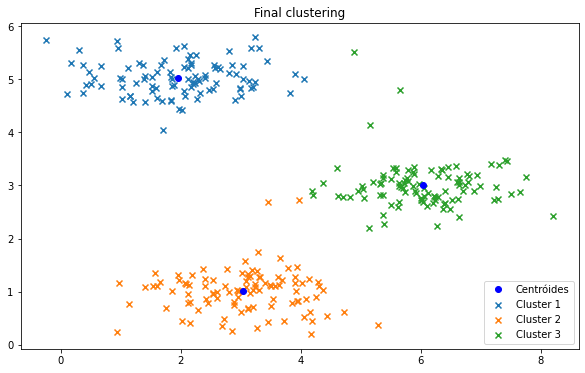

In [221]:
# Localização gráfica dos centróides após a 10ª iteração
plt.figure(figsize=(10,6))

# Plot final clustering.
plt.scatter(X[np.where(idx == 0),0],X[np.where(idx == 0),1], marker = 'x', label = 'Cluster 1')
plt.scatter(X[np.where(idx == 1),0],X[np.where(idx == 1),1], marker = 'x', label = 'Cluster 2')
plt.scatter(X[np.where(idx == 2),0],X[np.where(idx == 2),1], marker = 'x', label = 'Cluster 3')

# Centróide de cada grupo
plt.plot(centroids[:,0], centroids[:,1], 'bo', label = 'Centróides')

plt.legend(loc = 4)
plt.title('Final clustering')
plt.show()

## 3.4. k-Means aplicado ao conjunto de dados de exemplo

**Objetivo da questão**

* Executar o algoritmo K-means em um conjunto 2D para ajudar a entender o funcionamento do K-means.

Nas seções anteriores foi possível observar a construção e a execução do algoritmo k-Means, sem visualizar o processo iterativo do algoritmo.

Cada gráfico abaixo corresponde a uma iteração (dentro do número de iterações predefinido), possibilitando uma visão do processo de convergência dos centróides a cada cluster constituinte. Como esperado, o gráfico da primeira iteração mostra que os centróides iniciais não são os pontos centrais de cada cluster. Por outro lado, no gráfico da 10ª iteração é possível observar que os centróides são, de fato, os pontos centrais dos clusters.

De forma resumida, os gráficos abaixos mostram as seguintes etapas do algoritmo k-Means:

* Escolha dos centróides aleatórios como centróides iniciais, que representarão o centro de cada um dos clusters.

* Atribuição de cada observação do conjunto de dados ao cluster, cujo centróide esteja mais próximo.

* Para cada cluster, é realizado novamente o cálculo de novos centróides (atualização dos centróides).

Os dois últimos pontos foram repetidos até a 10ª iteração.

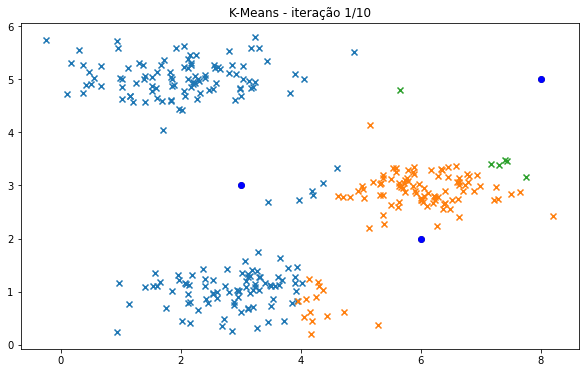

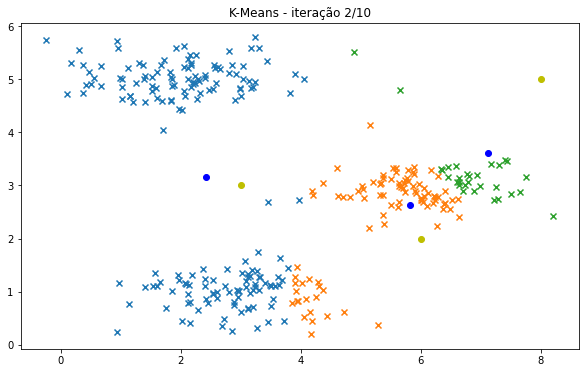

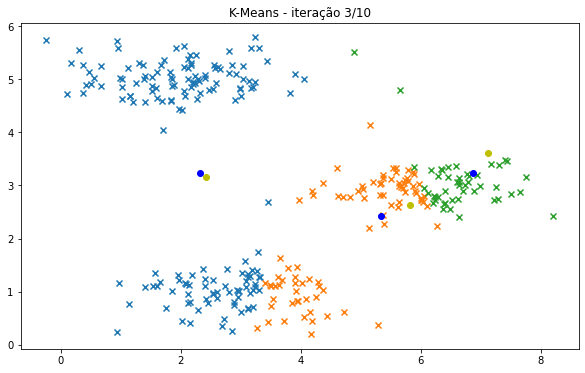

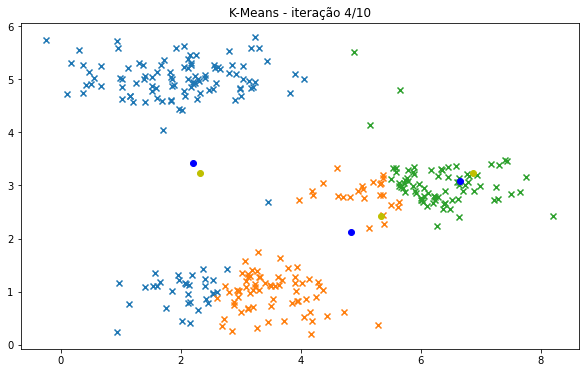

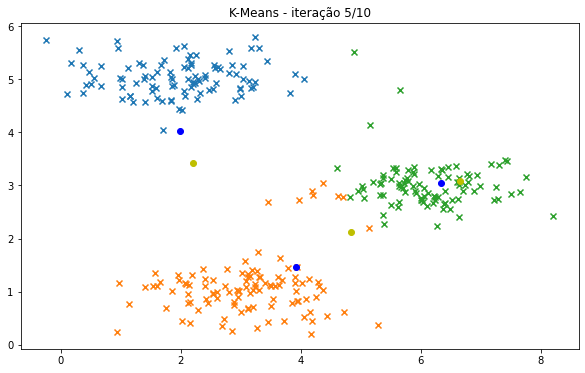

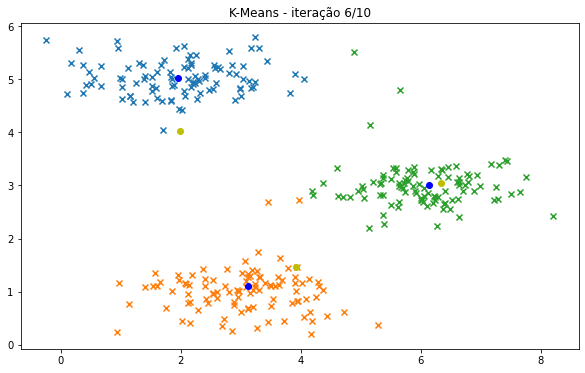

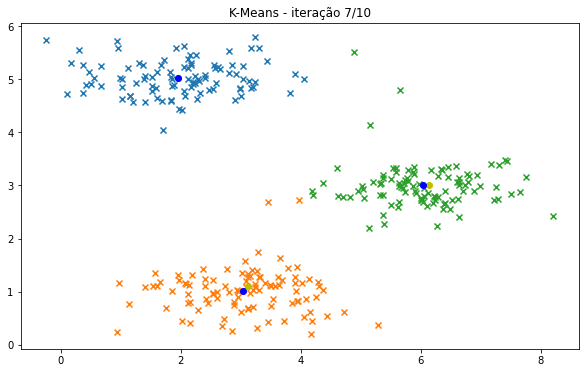

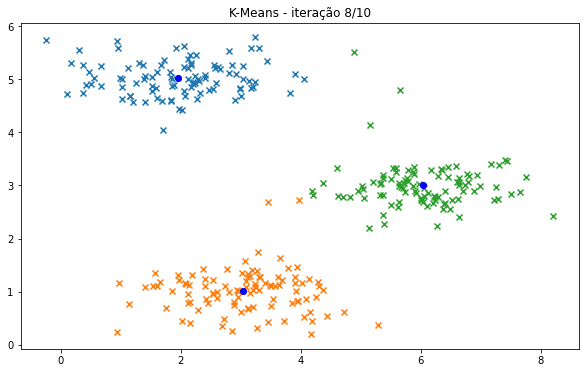

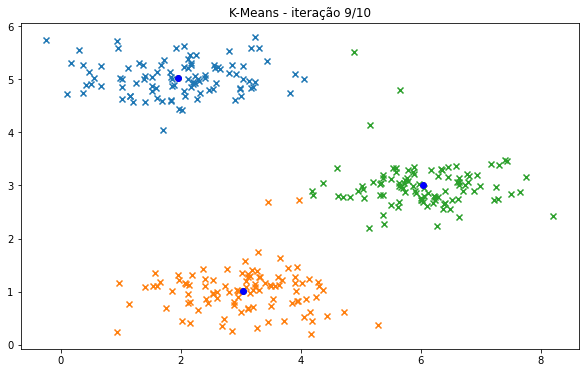

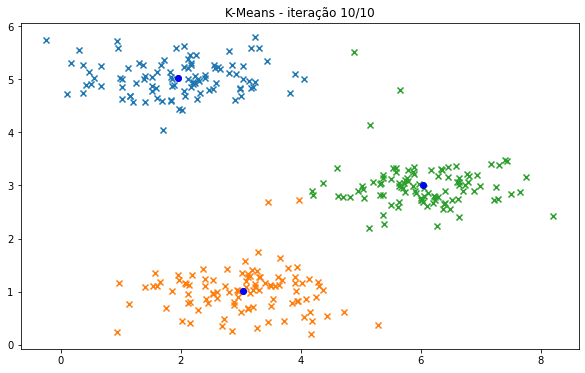

In [224]:
# Execução do algoritmo k-Means para 10 iterações
K = 3                                                     # nº de centroides
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])    # Valores arbitrários para os centróides iniciais
max_iters = 10                                            # nº de iterações (ponto de parada)

centroids, idx = run_kmeans(X, initial_centroids, max_iters, plot_progress = True)

## 3.5. Inicialização Aleatória

**Objetivo da questão**

* Utilizar a função `kmeans_init_centroids`.

Nas seções anteriores, o algoritmo k-Means foi executado considerando a definição pré-determinada dos centróides. Por outro lado, é possível executar o algoritmo considerando geração aleatória dos valores iniciais dos centróides.

A função `kmeans_init_centroids`a seleção aleatória das observações do conjunto de dados para o cálculo dos valores iniciais dos centróides.

In [225]:
# Cálculo dos valores iniciais aleatórios dos centróides
def kmeans_init_centroids(X, K):
    return X[np.random.choice(X.shape[0], K, replace=False)]

Uma vez realizada a inicialização aleatória dos valores dos centróides, serão repetidas etapas de convergência entre os centróides e os respectivos clusters.

In [226]:
initial_centroids = kmeans_init_centroids(X, K)

print('Centróides com inicialização aleatória: \n{}'.format(initial_centroids.T))

Centróides com inicialização aleatória: 
[[2.16979227 3.00677254 6.64078939]
 [5.27435354 0.62519128 2.41068839]]


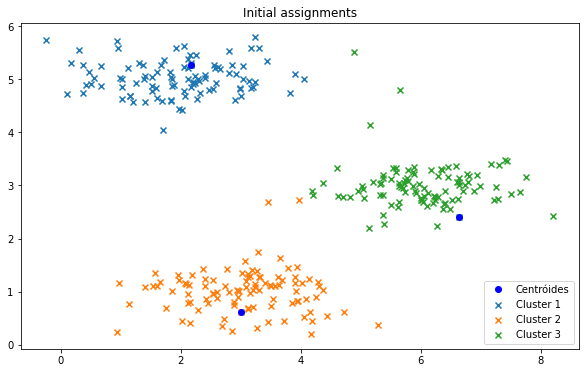

In [227]:
# Localização gráfica dos centróides iniciais
plt.figure(figsize=(10,6))

# Gráfico das atribuições iniciais das observaões aos clusters
plt.scatter(X[np.where(idx == 0),0],X[np.where(idx == 0),1], marker = 'x', label = 'Cluster 1')
plt.scatter(X[np.where(idx == 1),0],X[np.where(idx == 1),1], marker = 'x', label = 'Cluster 2')
plt.scatter(X[np.where(idx == 2),0],X[np.where(idx == 2),1], marker = 'x', label = 'Cluster 3')

# Centróide de cada grupo
plt.plot(initial_centroids[:,0], initial_centroids[:,1], 'bo', label = 'Centróides')

plt.legend(loc = 4)
plt.title('Initial assignments')
plt.show()

In [228]:
# Execução do algoritmo k-Means para 10 iterações
K = 3                                                     # nº de centroides
max_iters = 10                                            # nº de iterações (ponto de parada)

centroids, idx = run_kmeans(X, initial_centroids, max_iters, plot_progress = False)
print('Centróides resultantes após 10 iterações: \n{}'.format(centroids.T))

Centróides resultantes após 10 iterações: 
[[1.95399466 3.04367119 6.03366736]
 [5.02557006 1.01541041 3.00052511]]


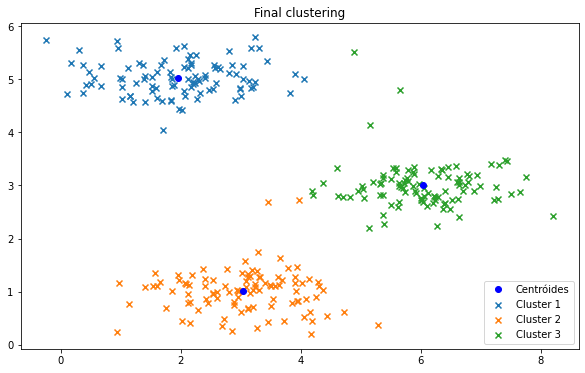

In [229]:
# Localização gráfica dos centróides após a 10ª iteração
plt.figure(figsize=(10,6))

# Plot final clustering.
plt.scatter(X[np.where(idx == 0),0],X[np.where(idx == 0),1], marker = 'x', label = 'Cluster 1')
plt.scatter(X[np.where(idx == 1),0],X[np.where(idx == 1),1], marker = 'x', label = 'Cluster 2')
plt.scatter(X[np.where(idx == 2),0],X[np.where(idx == 2),1], marker = 'x', label = 'Cluster 3')

# Centróide de cada grupo
plt.plot(centroids[:,0], centroids[:,1], 'bo', label = 'Centróides')

plt.legend(loc = 4)
plt.title('Final clustering')
plt.show()

# 4. Detecção de Anomalias

**Bibliotecas necessárias para a questão 4**

In [230]:
# Leitura de arquivos ".mat"
import scipy.io as sio

# Manipulação de dados tabulares
import numpy as np

# Plotar gráficos
import matplotlib.pyplot as plt

# Biblioteca de distribuições de probabilidade e funções estatísticas
from scipy import stats

**Objetivo da questão**

* Utilizar um conjunto de dados 2D que permitirá a visualização da execução do algoritmo.

* Ajustara uma distribuição gaussiana e encontrat os valores que têm probabilidade muito baixa e que podem  ser considerados anomalias.

**Aspectos conceituais**

O processo de detecção de anomalias também é conhecido como detecção de outlier, cujo objetivo reside na procura de ocorrências de observações ou eventos raros e que não ocorrem normalmente (com base nos dados amostrais). Diante disso, o algoritmo de detecção de anomalias busca aprender quais dados são considerados normais e, a partir deste conhecimento, detectar instâncias consideradas anômalas.

**Leitura dos dados**

In [231]:
data = sio.loadmat('Data/ex8data1.mat')
X = data['X']

**Visualização dos dados**

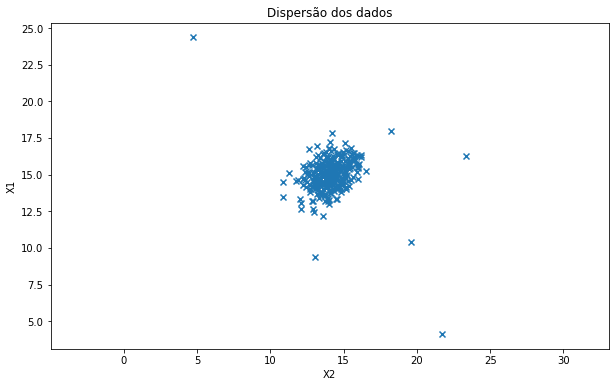

In [232]:
plt.figure(figsize = (10,6))
plt.scatter(X[:,0], X[:,1], marker='x')
plt.ylabel('X1')
plt.xlabel('X2')
plt.title('Dispersão dos dados')
plt.axis('equal')
plt.show()

Pelo gráfico acima é possível observar que alguns pontos possuem um comportamento que distoa do comportamento da maioria das observações (outliers).

## 4.1. Distribuição Gaussiana

**Objetivo da questão**

* Ajustar um modelo à distribuição dos dados.

* Estimar a distribuição gaussina para cada uma das características $x_{j}$.

Para executar o algoritmo para detecção de anomalias é necessário, em primeiro lugar, ajustar um modelo para a distribuição dos dados (distribuição Gaussiana). Diante disso, o algoritmo de detecção de anomalias visará identificar as observações que são estatisticamente diferentes das demais observações.

Obs.: Representação de uma distribuição Gaussiana

$$
p \left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left [ - \frac{(x - \mu)^2}{2 \sigma^2} \right ]
$$

onde $\mu$ e $\sigma^2$ são média e desvio padrão de $x$, respectivamente.

Obs.: Tanto o ajuste de um modelo gaussiano à distribuição dos dados quanto a estimação da distribuição gaussiana para cada uma das características serão realizados nas próximas seções.

## 4.2. Estimativa de parâmetros para uma gaussiana

**Objetivo da questão**

* Implementar o código `estimate_gaussian_params`.

* Visualizar os contornos da distribuição gaussiana ajustada.

**Estimação dos parâmetros da distribuição Gaussiana**

Dada um conjunto $\left \{ x^{(1)}, \dots, x^{(n)} \right \}$, com $x^{(i)} \in \mathbb{R}^n$, é necessário estimar a distribuição Gaussiana para cada uma das características $x_j$. Além disso, para cada característica $x_j$, com $j=1, \dots, n$, é preciso estimar os parâmetros $\mu_j$ e $\sigma^2_j$ que se encaixamn nos dados na $j$-ésima dimensão $\left \{ x^{(1)}_j, \dots, x^{(m)}_j \right \}$.

Para estimar $\mu_j$, utiliza-se a seguinte expressão:

$$
\mu_j = \frac{1}{m} \sum^{m}_{i=1} x^{(i)}_j
$$

Para estiar $\sigma^2_j$, utiliza-se a seguinte expressão:

$$
\sigma^2_j = \frac{1}{m} \sum^{m}_{i=1} \left(x^{(i)}_j - \mu_j \right)^2
$$

A função `estimate_gaussian_params` calcula as estimativas dos parâmetros de uma distribuição Gaussiana, utilizando as observações do conjunto de dados.

In [233]:
# Cálculo das estimativas dos parâmetros de uma distribuição gaussiana
def estimate_gaussian_params(X):
    mu = X.mean(axis = 0)
    sigma2 = X.var(axis = 0)
    return (mu, sigma2)

In [234]:
mu, sigma2 = estimate_gaussian_params(X)
print("Valores de mu: {}".format(mu))
print("Valores de sigma2: {}".format(sigma2))

Valores de mu: [14.11222578 14.99771051]
Valores de sigma2: [1.83263141 1.70974533]


**Visualização das curvas de contorno da distribuição gaussiana**

Uma vez estimados os parâmetros da distribuição Gaussiana, o próximo passo é o cálculo das probabilidades (geradas pela distribuição) para cada uma das observações contidas no conjunto de dados, realizada por meio da função `bivariate_normal`. Esta função será utilizada para encontrar a densidade de probabilidade, $p(x)$, de que algum exemplo do conjunto de dados seja, ou não, anômalo (com base em algum valor de threshold).

In [235]:
# Função para o cálculo do valor da distribuição gaussiana biavariada (para o esboço das linhas de contorno)
def bivariate_normal(X, Y, sigmax = 1.0, sigmay = 1.0, mux = 0.0, muy = 0.0, sigmaxy = 0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X - mux
    Ymu = Y - muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

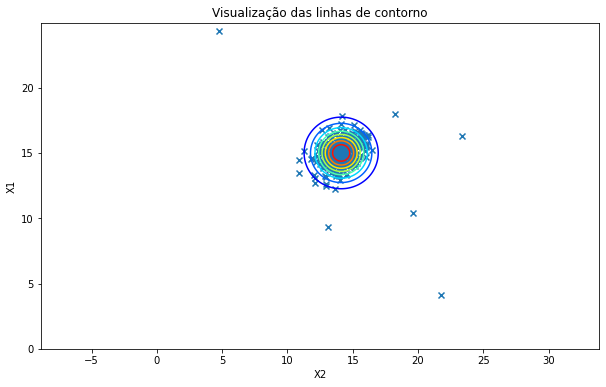

In [236]:
# Esboço do gráfico de dispersão e das linhas de contorno
plt.figure(figsize=(10,6))

# Esboço do gráfico de dispersão
plt.scatter(X[:,0], X[:,1], marker='x')

# Esboço das linhas de contorno
x = np.arange(0, 25, .025)
y = np.arange(0, 25, .025)
first_axis, second_axis = np.meshgrid(x, y)
Z = bivariate_normal(first_axis, second_axis, np.sqrt(sigma2[0]), np.sqrt(sigma2[1]), mu[0], mu[1])
plt.contour(first_axis, second_axis, Z, 10, cmap=plt.cm.jet)

plt.ylabel('X1')
plt.xlabel('X2')
plt.title('Visualização das linhas de contorno')
plt.axis('equal')
plt.show()

Pelo gráfico, é possível observar que os pontos que estão dentro do mesmo cluster possuem uma probabilidade alta e conforme se afastam (outliers) a probabilidade tende a ser zero.

## 4.3. Selecionando $\epsilon$

**Objetivo da questão**

* Complemtar a implementação do algoritmo para selecionar $\epsilon$ utilizando a medida $F_{1}$ em um conjunto de validação cruzada.

Uma vez calculada a densidade de probabilidade $p(x)$, a próxima etapa é o cálculo do valor de threshold a fim de investigar se uma observação é anômala ou não. A regra de decisão para que uma dada observação seja considerada anômala é:

* Se $p(x) < \epsilon$, então a observação será considerada anômala.

* Se $p(x) \geq \epsilon$, então a observação será considerada normal (não anômala).

A função `select_epsilon` localiza o valor ótimo de threshold ($\epsilon$) para a identificação de observações anômalas. Além disso, esta função retorna dois valores, o primeiro é o threshold selecionado (representado por `best_epsilon_value`) e o segundo é a métrica de avaliação (representado por `best_f1_value`). A métrica de avaliação F1 será calculada para anomalias previstas com base nos dados. O valor de threshold ($\epsilon$) com o maior valor de F1 será selecionado.

In [237]:
# Cálculo do valor de threshold
def select_epsilon(pval, yval):
    best_epsilon_value = 0
    best_f1_value = 0
    f1 = 0
    
    # Determinação do tamanho do passo para obtenção de um amplo intervalo de valores de threshold
    step_size = (pval.max() - pval.min()) / 1000
    
    print('step size: ' + str(step_size))
    
    for epsilon in np.arange(pval.min(), pval.max(), step_size):
        preds = (pval < epsilon)                                 # turn the vector of booleans to int
        
        tp = np.sum(np.logical_and(yval == 1, preds == 1))       # Prediction is True and yval = True
        fp = np.sum(np.logical_and(yval == 0, preds == 1))       # Prediction is True and yval is False
        fn = np.sum(np.logical_and(yval == 1, preds == 0))       # Yval is True and prediction is false
        
        precision = (tp/(tp + fp))
        recall = (tp/(tp + fn))
        f1 = (2*precision*recall)/(precision + recall)
        
        if f1 > best_f1_value:
            best_f1_value = f1
            best_epsilon_value = epsilon
    return best_epsilon_value, best_f1_value

In [239]:
# Load validation dataset
Xval = data['Xval']
yval = data['yval'].flatten()

stddev = np.sqrt(sigma2)

pval = np.zeros((Xval.shape[0], Xval.shape[1]))  
pval[:,0] = stats.norm.pdf(Xval[:,0], mu[0], stddev[0])  
pval[:,1] = stats.norm.pdf(Xval[:,1], mu[1], stddev[1])  
print(np.prod(pval, axis=1).shape)

epsilon, _ = select_epsilon(np.prod(pval, axis=1), yval)  
print('Melhor valor encontrado para epsilon: ' + str(epsilon))

(307,)
step size: 8.990852779269493e-05
Melhor valor encontrado para epsilon: 8.990852779269493e-05


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


<Figure size 432x288 with 0 Axes>

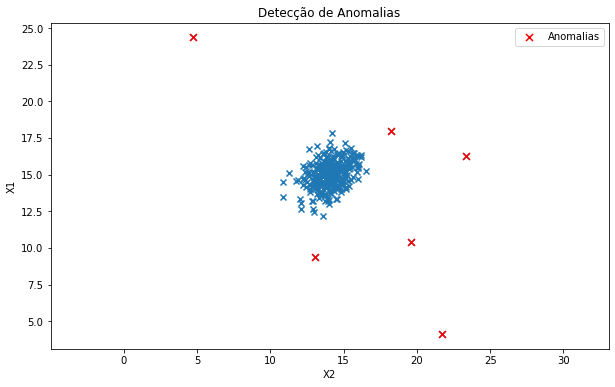

In [241]:
# Cálculo da densidade de probabilidade de cada um dos valores do dataset em relação a distribuicao gaussiana
p = np.zeros((X.shape[0], X.shape[1]))  
p[:,0] = stats.norm.pdf(X[:,0], mu[0], stddev[0])  
p[:,1] = stats.norm.pdf(X[:,1], mu[1], stddev[1])

# Detecção de exemplos anômalos no conjunto de dados
anomalies = np.where(np.prod(p, axis=1) < epsilon)

# Esboço do gráfico de dispersão com destaque para os exemplos anômalos
plt.clf()
plt.figure(figsize = (10,6))
plt.scatter(X[:,0], X[:,1], marker = 'x')  
plt.scatter(X[anomalies[0],0], X[anomalies[0],1], s=50, color = 'r', marker = 'x', label = 'Anomalias')  
plt.title('Detecção de Anomalias')
plt.ylabel('X1')
plt.xlabel('X2')
plt.legend(loc = 1)
plt.axis('equal')
plt.show()

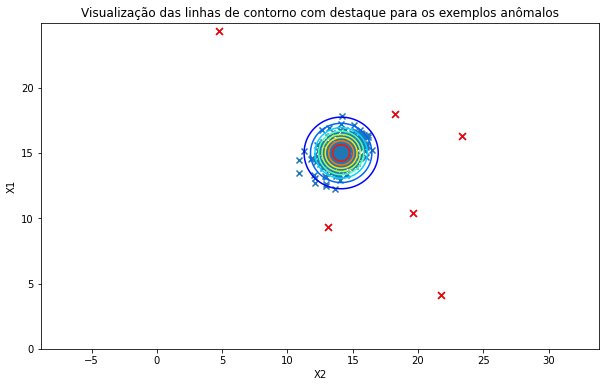

In [242]:
# Esboço do gráfico de dispersão e das linhas de contorno, com destaque para os exemplos anômalos
plt.figure(figsize=(10,6))

# Esboço do gráfico de dispersão
plt.scatter(X[:,0], X[:,1], marker='x')

# Esboço das linhas de contorno
x = np.arange(0, 25, .025)
y = np.arange(0, 25, .025)
first_axis, second_axis = np.meshgrid(x, y)
Z = bivariate_normal(first_axis, second_axis, np.sqrt(sigma2[0]), np.sqrt(sigma2[1]), mu[0], mu[1])
plt.contour(first_axis, second_axis, Z, 10, cmap=plt.cm.jet)

# Destaque para os exemplos anômalos
plt.scatter(X[anomalies[0],0], X[anomalies[0],1], s=50, color = 'r', marker = 'x', label = 'Anomalias') 

plt.ylabel('X1')
plt.xlabel('X2')
plt.title('Visualização das linhas de contorno com destaque para os exemplos anômalos')
plt.axis('equal')
plt.show()

# Referências

* Notebooks apresentados durante as aulas.

* Andreas C. Müller & Sarah Guido (2017). Introduction to Machine Learning with Python: A Guide for Data Scientists. Editora O'Reilly.

* Aurélien Géron (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. Editora: O'Reilly - 2ª Edição.

* Chris Albon (2018). Machine Learning with Pytho Cookbook: Pratical Solutions from Preprocessing to Deep Learning. Editora O'Reilly.

* Dipanjan Sarkar, Raghav Bali & Tushar Sharma (2018). Practical Machine Learning with Python: A Problem-Solver’s Guide to Building Real-World Intelligent Systems. Editora: Apress.

* Ian H. Witten, Eibe Frank, Mark A. Hall, & Christopher J. Pal (2017). Data Mining: Pratical Machine Learning Tools and Techniques. Editora Elsevier, 4ª Edição.

* Ivan Vasilev, Daniel Slater, Gianmario Spacagna, Peter Roelants, & Valentino Zocca (). Python Deep Learning: Exploring deep learning techniques and neural network architectures with PyTorch, Keras, and TensorFlow. Editora: Packt - 2ª Edição.

* Jake VanderPlas (2017). Python Data Science Handbook: Essential Tools for Working with Data. Editora: O'Reilly.

* José Unpingco (2019). Python for Probability, Statistics, and Machine Learning. Editora: Springer - 2ª edição.

* Pratap Dangeti (2017). Statistics for Machine Learning: Build supervised, unsupervised, and reinforcement learning models using both Python and R. Editora: Packt.

* Sayan Mukhopadhyay (2018). Advanced Data Analytics using Python: with Machine Learning, Deep Learning and NLP Examples. Editora Apress.

* Sebastian Raschka & Vahid Mirjalili (2017). Python Machine Learning: Machine Learning and Deep Learning with Python, Scikit-Learn, and TensorFlow. Editora: Packt - 2ª Edição.